# Machine-Learning for DDOS attack detection
*Ayman BEN HAJJAJ & Jules RUBIN*

## Description
This study is the final project of the Machine-Learning II course at EFREI Paris (Master 1 Data Science & AI 2023).
This project aims to detect DDOS attacks in a network using machine learning. The dataset used is the [CIC-DDoS2019](https://www.kaggle.com/datasets/dhoogla/cicddos2019) dataset. This dataset contains 78 features and 430K rows. The dataset contains 18 types of attacks. The goal is to detect the attacks using machine learning.
The taxonomy of attacks present in the dataset are described in the research paper [DDoS Evaluation Dataset (CIC-DDoS2019)](https://www.unb.ca/cic/datasets/ddos-2019.html).

**Taxonomy of attacks present in the dataset:**

![Taxonomy of attacks](https://www.unb.ca/cic/_assets/images/ddostaxonomy.png)

As we have the choice on the type of attack to detect, we will focus on the detection of 3 types of attacks:
- UDP : UDP Flood attack
- Syn : Syn Flood attack
- DrDoS DNS : DNS amplification attack

We will also provide a method that can classify the benign traffic from the malicious traffic.

## Preprocessing

### Importing libraries and dataset

In [320]:
# making the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [321]:
df = pd.DataFrame()
df = pd.concat([df, pd.read_parquet('data/Syn-training.parquet')])
df = pd.concat([df, pd.read_parquet('data/DNS-testing.parquet')])
df = pd.concat([df, pd.read_parquet('data/UDP-training.parquet')])
df['Label'].value_counts()

Label
Syn          43302
Benign       32901
UDP          14792
DrDoS_DNS     3669
MSSQL          145
Name: count, dtype: int64

In [322]:
# We can remove the MSSQL data as it is not required for our analysis
df = df[df['Label'] != 'MSSQL']

In [323]:
df['Label'].value_counts()

Label
Syn          43302
Benign       32901
UDP          14792
DrDoS_DNS     3669
Name: count, dtype: int64

### Data cleaning

#### Dealing with missing values

In [324]:
# count the number of missing values in each column
df.isnull().sum().sort_values(ascending=False)

Protocol                0
CWE Flag Count          0
Fwd Avg Packets/Bulk    0
Fwd Avg Bytes/Bulk      0
Avg Bwd Segment Size    0
                       ..
Bwd IAT Total           0
Fwd IAT Min             0
Fwd IAT Max             0
Fwd IAT Std             0
Label                   0
Length: 78, dtype: int64

#### Dealing with outliers

In [325]:
# check for duplicate rows
df.duplicated().sum()

194

In [326]:
# remove duplicate rows
df.drop_duplicates(inplace=True)

We do not have any missing values in the dataset. However, we have some duplicates. We will remove them.

#### Dealing with categorical variables

In [327]:
# count the number of unique values in each column
df.nunique().sort_values(ascending=True).head(25)

Bwd Avg Bulk Rate          1
Bwd Avg Packets/Bulk       1
Bwd Avg Bytes/Bulk         1
Fwd Avg Bulk Rate          1
Fwd Avg Packets/Bulk       1
Fwd Avg Bytes/Bulk         1
ECE Flag Count             1
Fwd URG Flags              1
Bwd PSH Flags              1
Bwd URG Flags              1
PSH Flag Count             1
FIN Flag Count             1
URG Flag Count             2
Fwd PSH Flags              2
RST Flag Count             2
ACK Flag Count             2
CWE Flag Count             2
SYN Flag Count             2
Protocol                   3
Label                      4
Down/Up Ratio             15
Bwd IAT Min              105
Bwd Packet Length Min    195
Fwd Act Data Packets     212
Total Fwd Packets        263
dtype: int64

As some columns has only one unique value, they do not bring any information. We will remove them.
We can also see that some columns are categorical variables. We will convert them to numerical variables using the OneHotEncoder.

In [328]:
one_value_cols = [col for col in df.columns if df[col].nunique() <= 1]
df = df.drop(one_value_cols, axis=1)

In [329]:
three_value_cols = [col for col in df.columns if df[col].nunique() <= 3]
# One Hot Encoding
df = pd.get_dummies(df, columns=three_value_cols)

### Balancing the dataset

In [330]:
df['Label'].value_counts()

Label
Syn          43302
Benign       32707
UDP          14792
DrDoS_DNS     3669
Name: count, dtype: int64

In [331]:
# As the dataset is imbalanced, we will balance it by taking 3000 samples from each class
balanced = pd.DataFrame()
balanced = pd.concat([balanced, df[df['Label'] == 'Syn'].sample(n=3500)])
balanced = pd.concat([balanced, df[df['Label'] == 'DrDoS_DNS'].sample(n=3500)])
balanced = pd.concat([balanced, df[df['Label'] == 'UDP'].sample(n=3500)])
balanced = pd.concat([balanced, df[df['Label'] == 'Benign'].sample(n=3500)])
df = balanced.copy()
# free up memory
del balanced

### Handling outliers

In [332]:
df.describe()

Flow Duration  Total Fwd Packets  Total Backward Packets   
count   1.400000e+04       14000.000000            14000.000000  \
mean    1.358191e+07           7.316429                3.643143   
std     2.685415e+07          24.221196               32.461735   
min     1.000000e+00           1.000000                0.000000   
25%     4.900000e+01           2.000000                0.000000   
50%     1.051565e+05           4.000000                0.000000   
75%     5.770426e+06           6.000000                2.000000   
max     1.199822e+08        1308.000000             2025.000000   

       Fwd Packets Length Total  Bwd Packets Length Total   
count              14000.000000              1.400000e+04  \
mean                1602.256958              2.127737e+03   
std                 6015.608887              5.235179e+04   
min                    0.000000              0.000000e+00   
25%                   60.000000              0.000000e+00   
50%                  750.000000              0.000000e+00   
75%                 2088.000000              2.400000e+01   
max               138520.000000              3.187726e+06   

       Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean   
count           14000.000000           14000.000000            14000.000000  \
mean              395.965363             339.608795              353.546906   
std               511.710205             484.858276              481.514679   
min                 0.000000               0.000000                0.000000   
25%                 6.000000               6.000000                6.000000   
50%               349.000000              47.000000              128.066666   
75%               416.250000             330.000000              359.500000   
max              3589.000000            1472.000000             1601.000000   

       Fwd Packet Length Std  Bwd Packet Length Max  ...   
count           14000.000000           14000.000000  ...  \
mean               20.258896              91.575287  ...   
std                72.535515             424.679138  ...   
min                 0.000000               0.000000  ...   
25%                 0.000000               0.000000  ...   
50%                 0.000000               0.000000  ...   
75%                22.516661               6.000000  ...   
max              1201.630981            3621.000000  ...   

       Fwd Act Data Packets  Fwd Seg Size Min   Active Mean    Active Std   
count          14000.000000      1.400000e+04  1.400000e+04  1.400000e+04  \
mean               5.365714     -2.044397e+07  5.495549e+04  5.462107e+04   
std               17.063245      1.460980e+08  3.605486e+05  3.210759e+05   
min                0.000000     -1.408238e+09  0.000000e+00  0.000000e+00   
25%                1.000000      8.000000e+00  0.000000e+00  0.000000e+00   
50%                3.000000      2.000000e+01  0.000000e+00  0.000000e+00   
75%                5.000000      2.000000e+01  0.000000e+00  0.000000e+00   
max              998.000000      1.480000e+03  7.257890e+06  6.042106e+06   

         Active Max    Active Min    Idle Mean      Idle Std     Idle Max   
count  1.400000e+04  1.400000e+04      14000.0  1.400000e+04      14000.0  \
mean   1.279928e+05  2.382153e+04    4223603.0  9.721358e+05    5256465.5   
std    6.822359e+05  2.998180e+05    9558667.0  2.641004e+06   11133084.0   
min    0.000000e+00  0.000000e+00          0.0  0.000000e+00          0.0   
25%    0.000000e+00  0.000000e+00          0.0  0.000000e+00          0.0   
50%    0.000000e+00  0.000000e+00          0.0  0.000000e+00          0.0   
75%    0.000000e+00  0.000000e+00          0.0  0.000000e+00          0.0   
max    1.584826e+07  7.257890e+06  116132472.0  4.656503e+07  116132472.0   

           Idle Min  
count  1.400000e+04  
mean   3.320071e+06  
std    8.646279e+06  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    1.161325e+08  

[8 rows x 58 

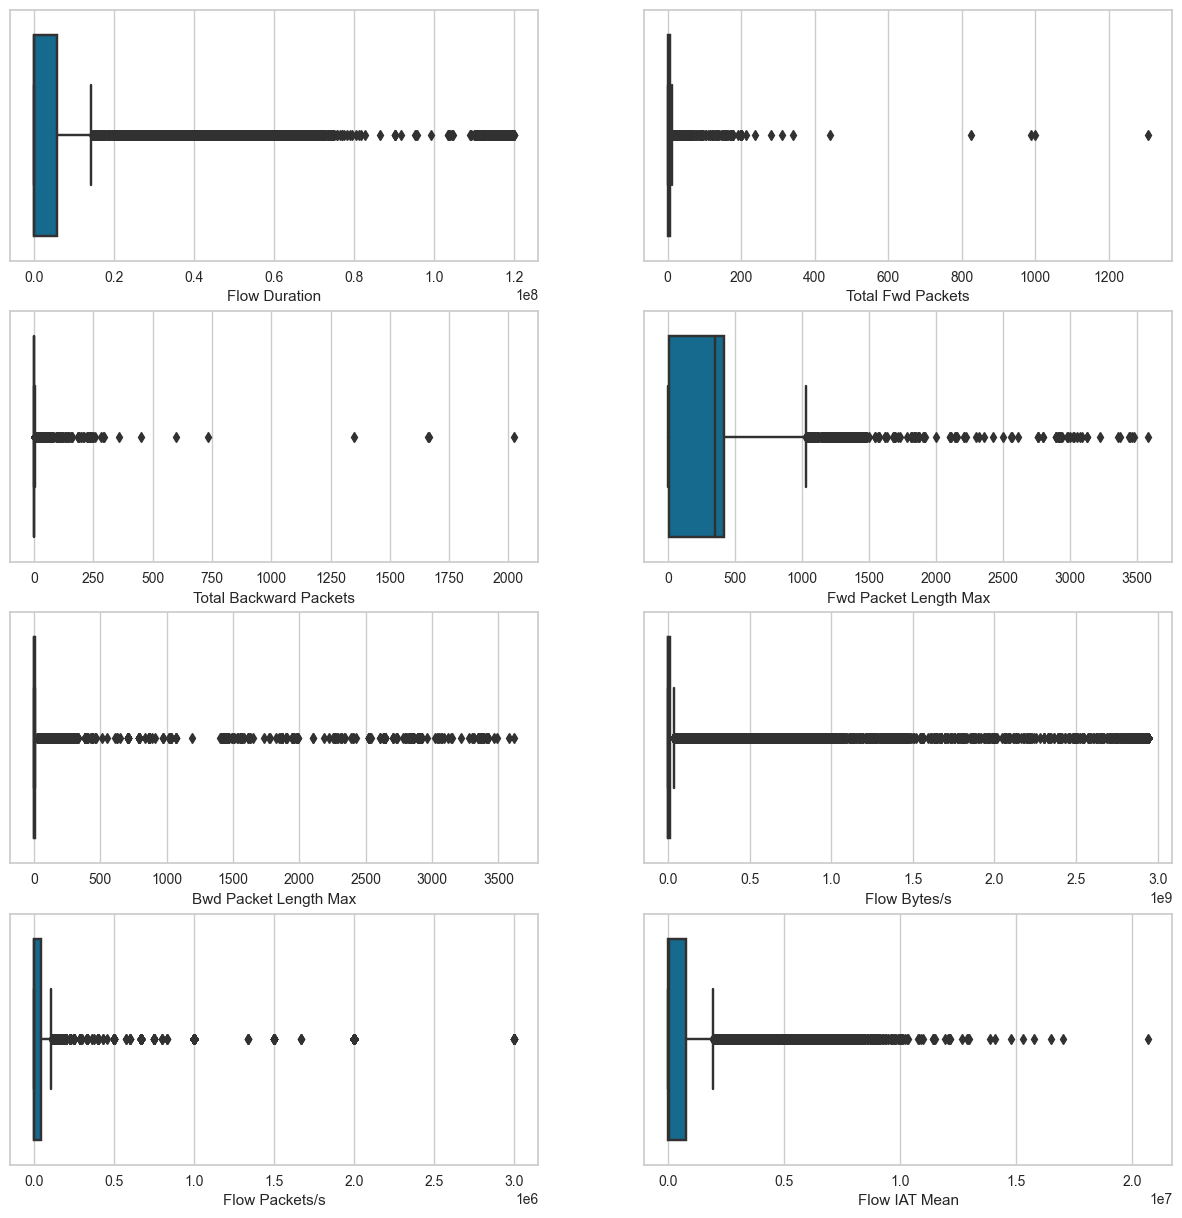

In [333]:
# check for the outliers
fig, ax = plt.subplots(4, 2, figsize=(15, 15))
# create a list of columns to check for outliers
outliers_col = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packet Length Max',
                'Bwd Packet Length Max', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std']
                

# create a for loop to iterate over the columns
for i in range(0, 4):
    for j in range(0, 2):
        col = outliers_col[i * 2 + j]
        # create a boxplot for each column
        sns.boxplot(x=df[col], ax=ax[i, j])
plt.show()

In [334]:
# remove the outliers using IsolationForest
from sklearn.ensemble import IsolationForest

# create an instance of the IsolationForest class
iso = IsolationForest(n_estimators=1000, max_samples='auto', contamination=float(0.05), max_features=1.0,
                        bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
# fit the model
yhat = iso.fit_predict(df.drop('Label', axis=1))
# select all rows that are not outliers
mask = yhat != -1
df = df[mask]
df.shape

(13301, 74)

In [335]:
df['Label'].value_counts()

Label
UDP          3500
Syn          3494
DrDoS_DNS    3488
Benign       2819
Name: count, dtype: int64

We can see that there is a few outliers among the attacks and around 20% of outliers among the benign traffic. We have removed them.

In [336]:
# put the Label colum in first place
df = pd.concat([df['Label'], df.drop('Label', axis=1)], axis=1)
df

Label  Flow Duration  Total Fwd Packets  Total Backward Packets   
33621     Syn       60004267                 10                       0  \
14621     Syn       55838899                 10                       2   
29867     Syn       64810622                  8                       2   
1125      Syn       60483048                 16                       8   
30397     Syn            175                  2                       2   
...       ...            ...                ...                     ...   
46310  Benign          26567                  3                       3   
67843  Benign          54464                  2                       2   
56900  Benign            155                  1                       2   
45526  Benign          65361                  2                       2   
68155  Benign          47205                  2                       2   

       Fwd Packets Length Total  Bwd Packets Length Total   
33621                      60.0                       0.0  \
14621                      60.0                      12.0   
29867                      48.0                      12.0   
1125                       96.0                      48.0   
30397                      12.0                      12.0   
...                         ...                       ...   
46310                      12.0                      76.0   
67843                      82.0                     114.0   
56900                       6.0                      12.0   
45526                      62.0                      94.0   
68155                      86.0                     118.0   

       Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean   
33621                    6.0                    6.0                     6.0  \
14621                    6.0                    6.0                     6.0   
29867                    6.0                    6.0                     6.0   
1125                     6.0                    6.0                     6.0   
30397                    6.0                    6.0                     6.0   
...                      ...                    ...                     ...   
46310                    6.0                    0.0                     4.0   
67843                   41.0                   41.0                    41.0   
56900                    6.0                    6.0                     6.0   
45526                   31.0                   31.0                    31.0   
68155                   43.0                   43.0                    43.0   

       Fwd Packet Length Std  ...  SYN Flag Count_0  SYN Flag Count_1   
33621               0.000000  ...              True             False  \
14621               0.000000  ...              True             False   
29867               0.000000  ...              True             False   
1125                0.000000  ...              True             False   
30397               0.000000  ...              True             False   
...                      ...  ...               ...               ...   
46310               3.464102  ...              True             False   
67843               0.000000  ...              True             False   
56900               0.000000  ...              True             False   
45526               0.000000  ...              True             False   
68155               0.000000  ...              True             False   

       RST Flag Count_0  RST Flag Count_1  ACK Flag Count_0  ACK Flag Count_1   
33621              True             False             False              True  \
14621              True             False             False              True   
29867              True             False             False              True   
1125               True             False             False              True   
30397              True             False             False              True   
...                 ...               ...               ...   

## Data visualization

### Distribution according to the attack type

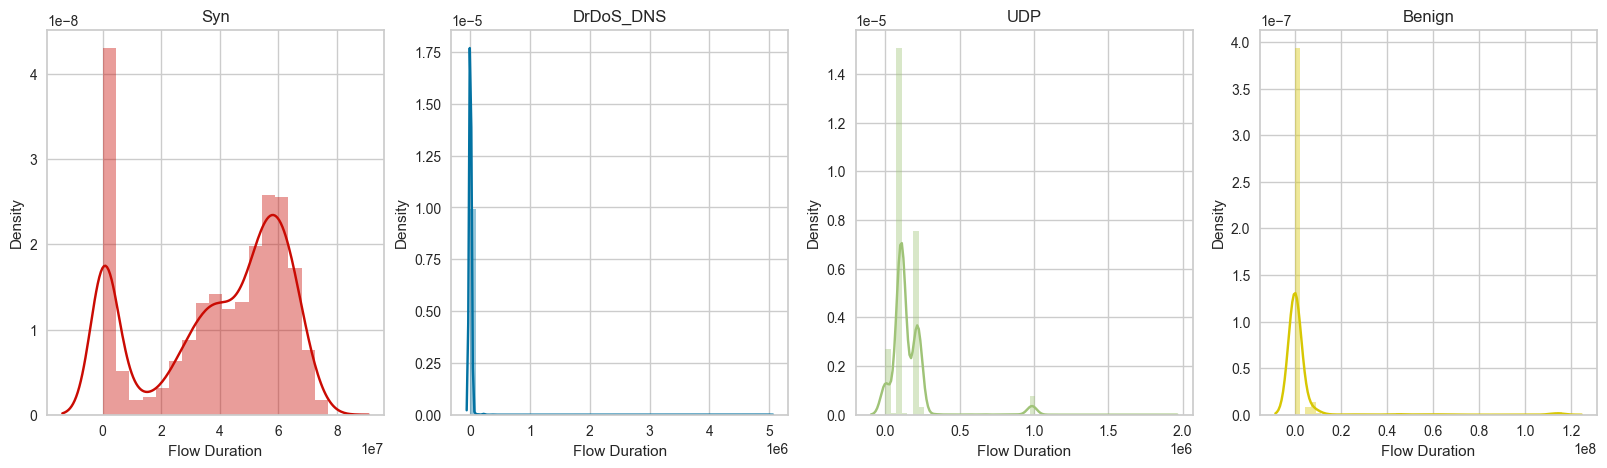

In [337]:
# Plot the distribution of the Flow Duration for each class
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.distplot(df[df['Label'] == 'Syn']['Flow Duration'], ax=ax[0], color='r')
ax[0].set_title('Syn')
sns.distplot(df[df['Label'] == 'DrDoS_DNS']['Flow Duration'], ax=ax[1], color='b')
ax[1].set_title('DrDoS_DNS')
sns.distplot(df[df['Label'] == 'UDP']['Flow Duration'], ax=ax[2], color='g')
ax[2].set_title('UDP')
sns.distplot(df[df['Label'] == 'Benign']['Flow Duration'], ax=ax[3], color='y')
ax[3].set_title('Benign')
plt.show()

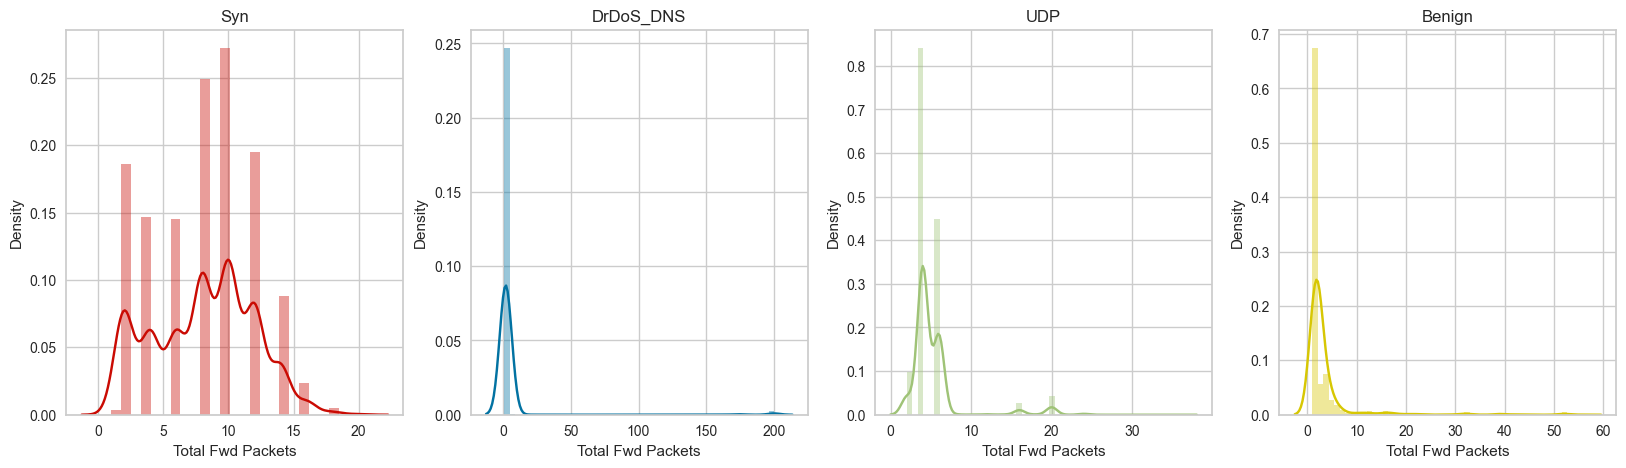

In [338]:
# Plot the distribution of the Total Fwd Packets for each class
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.distplot(df[df['Label'] == 'Syn']['Total Fwd Packets'], ax=ax[0], color='r')
ax[0].set_title('Syn')
sns.distplot(df[df['Label'] == 'DrDoS_DNS']['Total Fwd Packets'], ax=ax[1], color='b')
ax[1].set_title('DrDoS_DNS')
sns.distplot(df[df['Label'] == 'UDP']['Total Fwd Packets'], ax=ax[2], color='g')
ax[2].set_title('UDP')
sns.distplot(df[df['Label'] == 'Benign']['Total Fwd Packets'], ax=ax[3], color='y')
ax[3].set_title('Benign')
plt.show()

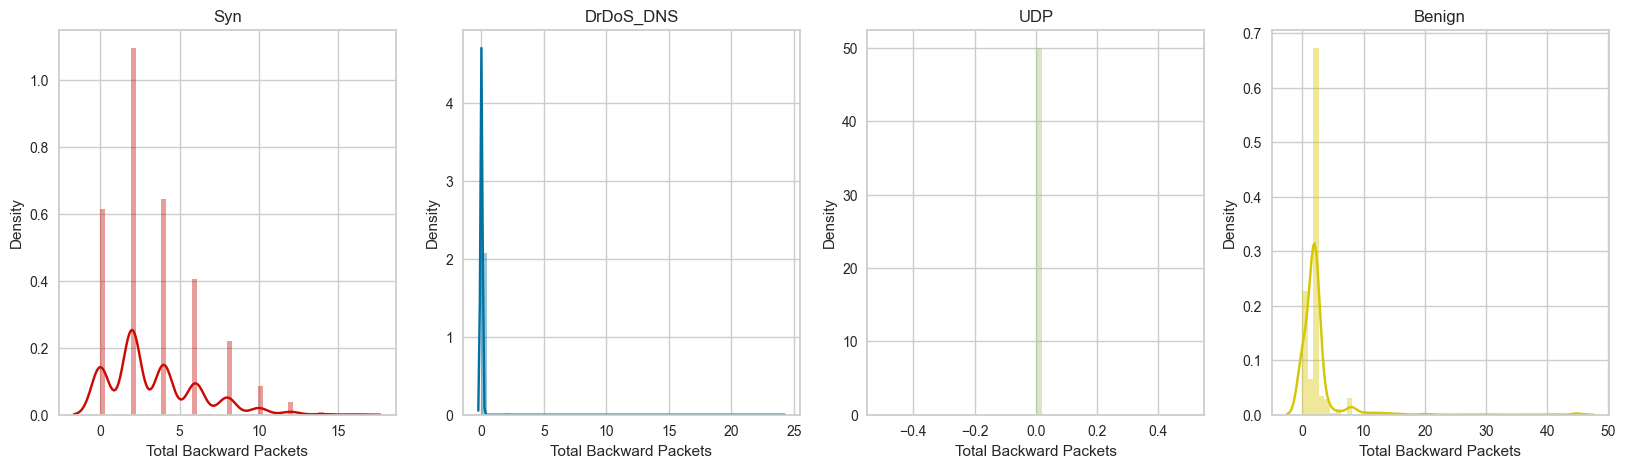

In [339]:
# Plot the distribution of the Total Backward Packets for each class
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.distplot(df[df['Label'] == 'Syn']['Total Backward Packets'], ax=ax[0], color='r')
ax[0].set_title('Syn')
sns.distplot(df[df['Label'] == 'DrDoS_DNS']['Total Backward Packets'], ax=ax[1], color='b')
ax[1].set_title('DrDoS_DNS')
sns.distplot(df[df['Label'] == 'UDP']['Total Backward Packets'], ax=ax[2], color='g')
ax[2].set_title('UDP')
sns.distplot(df[df['Label'] == 'Benign']['Total Backward Packets'], ax=ax[3], color='y')
ax[3].set_title('Benign')
plt.show()

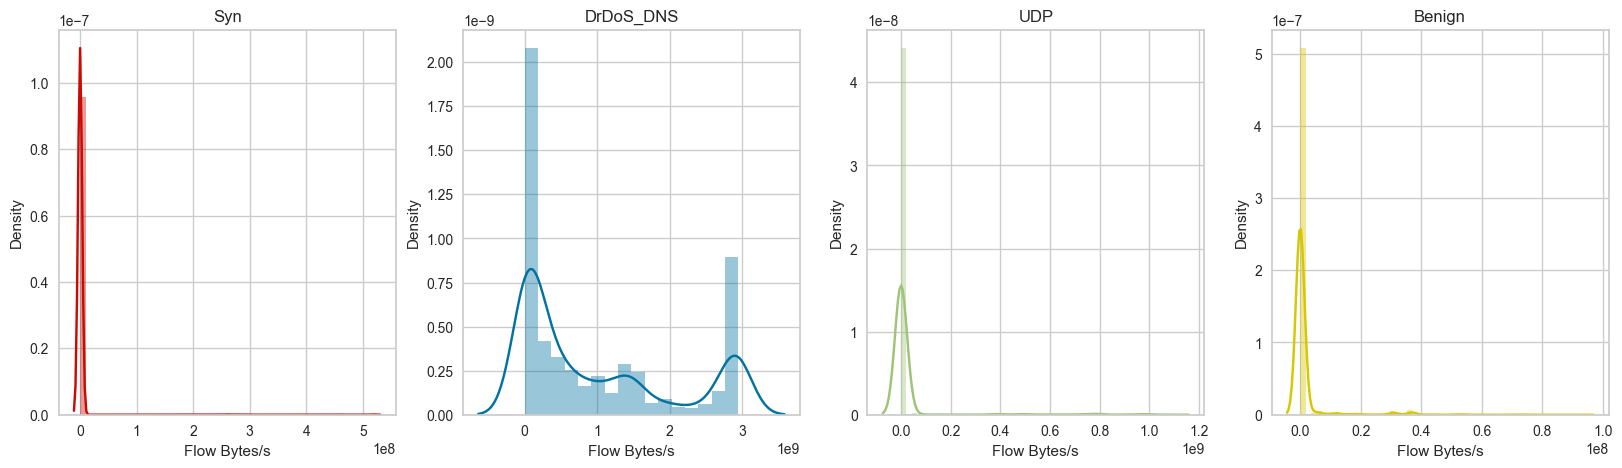

In [340]:
# Plot the distribution of the Flow Bytes/s for each class
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.distplot(df[df['Label'] == 'Syn']['Flow Bytes/s'], ax=ax[0], color='r')
ax[0].set_title('Syn')
sns.distplot(df[df['Label'] == 'DrDoS_DNS']['Flow Bytes/s'], ax=ax[1], color='b')
ax[1].set_title('DrDoS_DNS')
sns.distplot(df[df['Label'] == 'UDP']['Flow Bytes/s'], ax=ax[2], color='g') 
ax[2].set_title('UDP')
sns.distplot(df[df['Label'] == 'Benign']['Flow Bytes/s'], ax=ax[3], color='y')
ax[3].set_title('Benign')
plt.show()

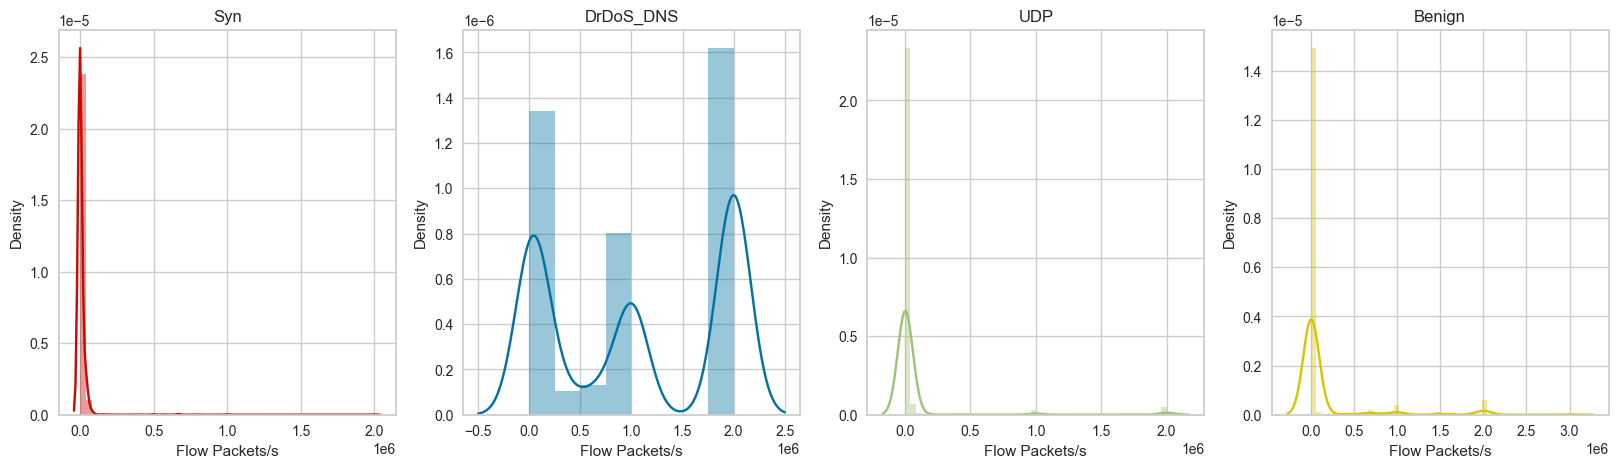

In [341]:
# Plot the distribution of the Flow Packets/s for each class
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.distplot(df[df['Label'] == 'Syn']['Flow Packets/s'], ax=ax[0], color='r')
ax[0].set_title('Syn')
sns.distplot(df[df['Label'] == 'DrDoS_DNS']['Flow Packets/s'], ax=ax[1], color='b')
ax[1].set_title('DrDoS_DNS')
sns.distplot(df[df['Label'] == 'UDP']['Flow Packets/s'], ax=ax[2], color='g')
ax[2].set_title('UDP')
sns.distplot(df[df['Label'] == 'Benign']['Flow Packets/s'], ax=ax[3], color='y')
ax[3].set_title('Benign')
plt.show()

We can see that the distribution of the Syn attack is very different from the other classes. The values can be very high when regarding the number of packets sent or the flow duration.
However, the DNS attack have some really different charasterisitcs to benign traffic. We can see that the Flow Bytes/s and Flow Packets/s are very high for the DNS attack.

These visualizations help us to have a better understanding of the characteristics of the attacks.

### Correlation matrix

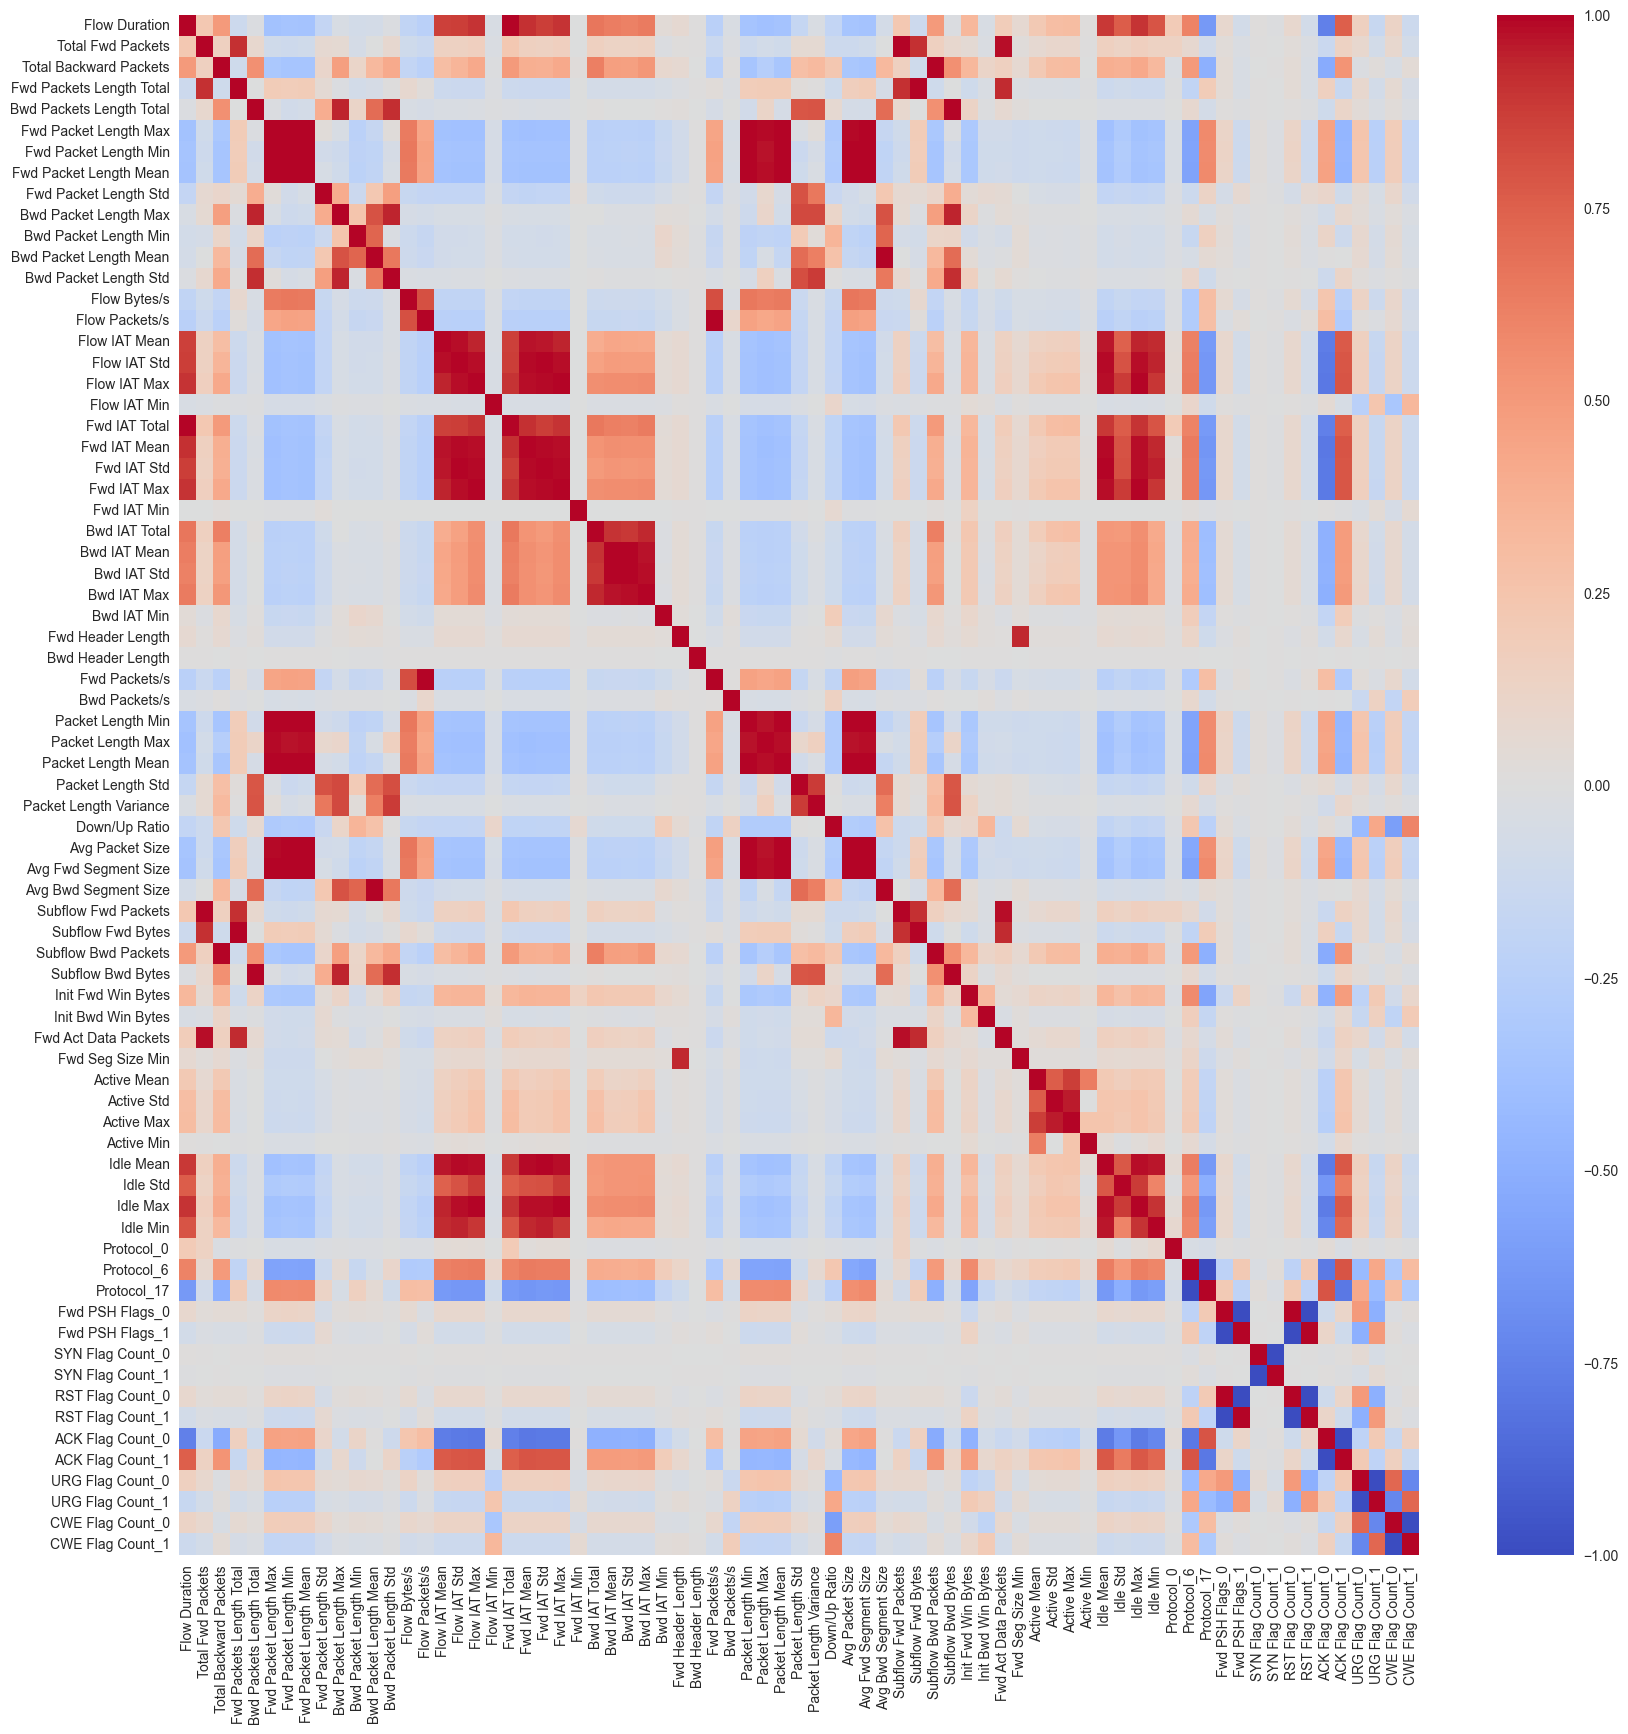

In [342]:
# Plot the correlation matrix
corr = df.drop('Label', axis=1).corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.show()

We can see that we have high correlation between some features such as Packets Min/Max/Mean and Fwd Packets Min/Max/Mean, Idle Mean/Std/Min/Max and Flow IAT Mean/Std/Min/Max, etc. The OneHotEncoder has created some columns that are perfectly anti-correlated as we can see with the last columns.

The correlations will be handled by the PCA after the Scaling.

## Feature Dimensionality Reduction

### PCA

In [343]:
# we standardize the features
from sklearn.preprocessing import StandardScaler
df.reset_index(inplace=True, drop=True)
# separate the features from the labels
X = df.drop('Label', axis=1)
y = df['Label']

# standardize the features
X = StandardScaler().fit_transform(X)

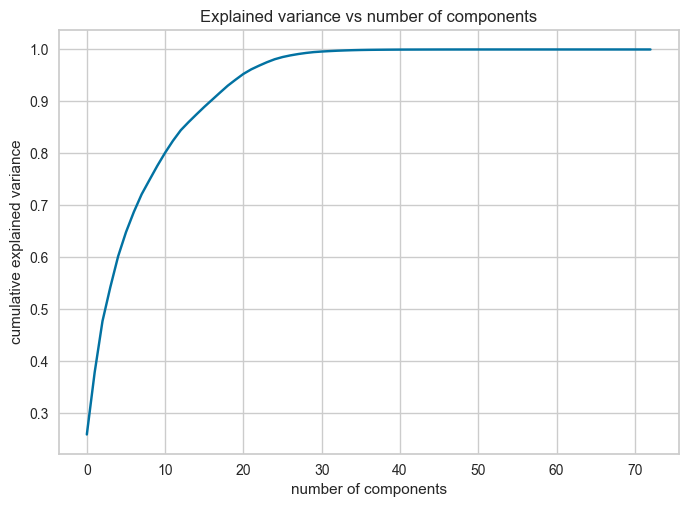

In [344]:
# find the optimal number of components
from sklearn.decomposition import PCA
df_pca = PCA().fit(X)
plt.plot(np.cumsum(df_pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Explained variance vs number of components')
plt.show()

We see that to get 80% of the explained variance, we need to keep 12 components.

In [345]:
pca = PCA(n_components=12)
principalComponents = pca.fit_transform(X)

# create a dataframe with the principal components
df_pca = pd.DataFrame(data=principalComponents, columns=['PC' + str(i) for i in range(1, 13)])

# concatenate the labels to the dataframe
df_pca = pd.concat([df_pca, df[['Label']]], axis=1)

# print the first 5 rows of the dataframe
df_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7   
0  7.298919 -2.327477 -0.325799 -0.107041 -0.221103 -1.471727 -3.132483  \
1  6.055641 -1.276781 -0.196096  0.024938 -0.381972 -1.081422 -2.290524   
2  9.762714 -3.362180  0.255827 -0.753408  0.136059 -1.612449 -3.987836   
3  8.218489 -1.682617  1.371132  0.442808  1.078799  2.184851  6.133343   
4  0.867070  1.853033 -1.160195 -0.158838 -1.295421  0.015884  0.125687   

        PC8       PC9      PC10      PC11      PC12 Label  
0  1.980625  0.048089 -0.278492  0.368048  0.440776   Syn  
1  1.573802  0.057907 -0.264950  0.237271  0.026703   Syn  
2  2.303934  0.100408 -0.697884  0.893012  1.216766   Syn  
3  0.664913 -0.016647  0.079524 -0.058986 -0.004627   Syn  
4  0.270532 -0.037963  0.172831 -0.545415 -1.272477   Syn

in order to plot the PCA, we will keep 2 components.

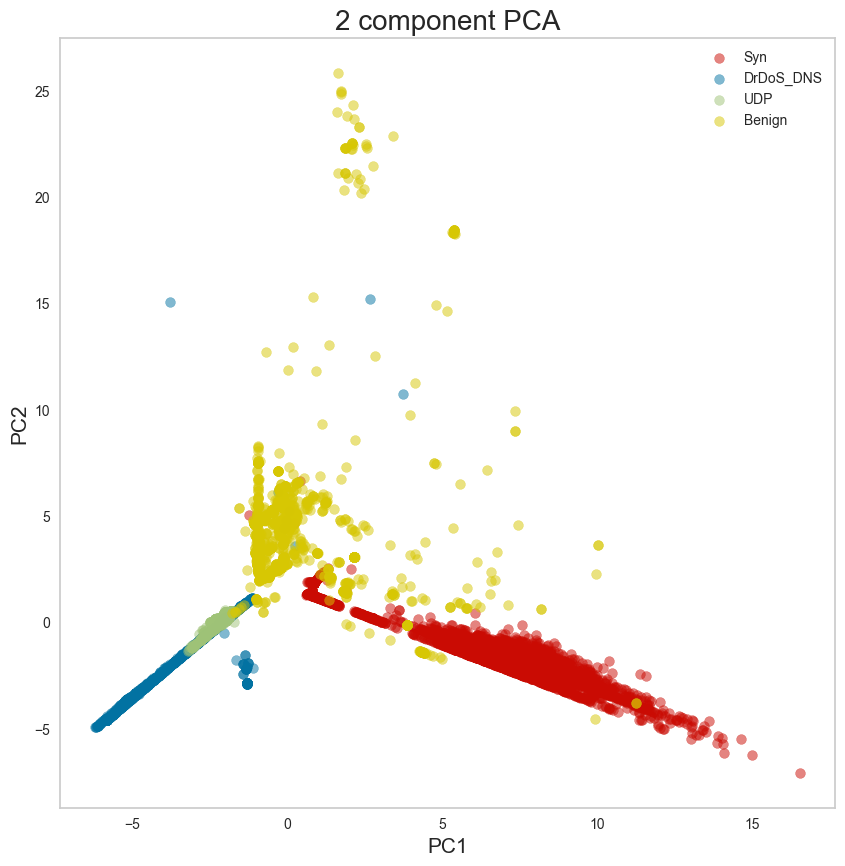

In [346]:
# plot 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_title('2 component PCA', fontsize=20)
targets = ['Syn', 'DrDoS_DNS', 'UDP', 'Benign']
colors = ['r', 'b', 'g', 'y']
for target, color in zip(targets, colors):
    indicesToKeep = df_pca['Label'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'PC1'], df_pca.loc[indicesToKeep, 'PC2'], c=color, s=50 , alpha=0.5)

ax.legend(targets)
ax.grid()
plt.show()


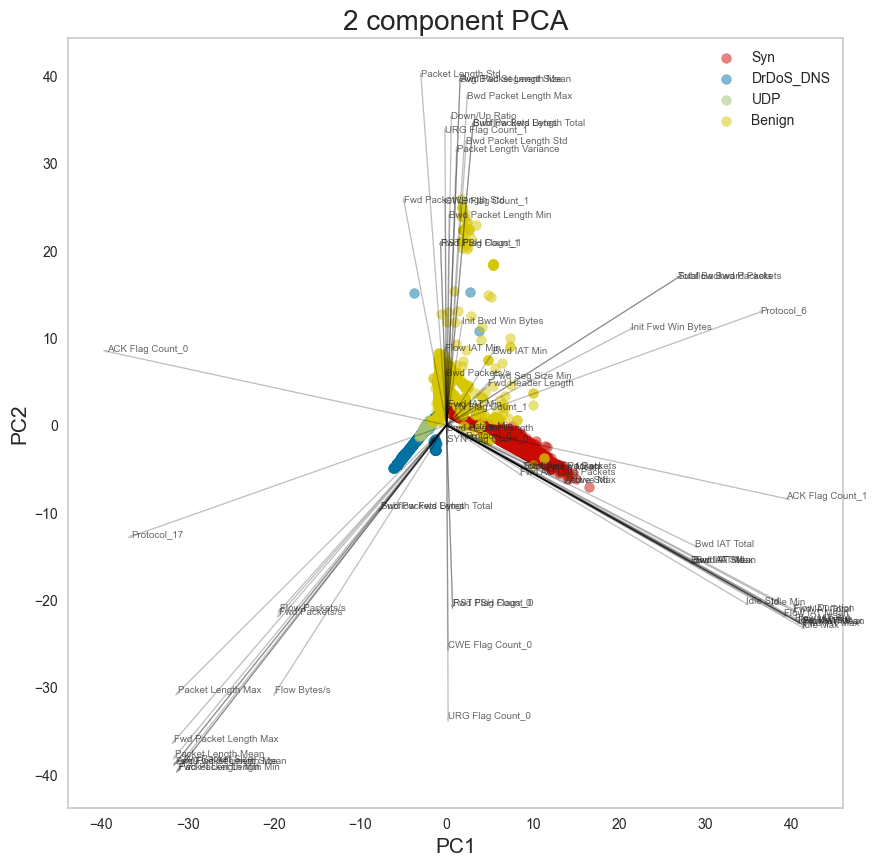

In [347]:
# plot 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_title('2 component PCA', fontsize=20)
targets = ['Syn', 'DrDoS_DNS', 'UDP', 'Benign']
colors = ['r', 'b', 'g', 'y']
for target, color in zip(targets, colors):
    indicesToKeep = df_pca['Label'] == target
    ax.scatter(df_pca.loc[indicesToKeep, 'PC1'], df_pca.loc[indicesToKeep, 'PC2'], c=color, s=50 , alpha=0.5)
for i, txt in enumerate(df.drop('Label', axis=1).columns):
    plt.arrow(0, 0, 200*pca.components_[0][i], 200*pca.components_[1][i], color='black', alpha=0.2, head_width=0.3, width=.1)
    plt.annotate(txt, (200*pca.components_[0][i], 200*pca.components_[1][i]), size=7, alpha=0.7)

ax.legend(targets)
ax.grid()
plt.show()

### Kernel PCA

In [348]:
# we do the same thing for a kernel PCA
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=12, kernel='rbf')
principalComponents = kpca.fit_transform(X)

# create a dataframe with the principal components
df_kpca = pd.DataFrame(data=principalComponents, columns=['PC' + str(i) for i in range(1, 13)])

# concatenate the labels to the dataframe
df_kpca = pd.concat([df_kpca, df[['Label']]], axis=1)

# print the first 5 rows of the dataframe
df_kpca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7   
0  0.697705 -0.148104 -0.361867 -0.095688 -0.231201 -0.206785  0.150385  \
1  0.609158 -0.226843 -0.370223 -0.099596 -0.239170 -0.173581  0.069581   
2  0.695524 -0.014916 -0.185120 -0.035152 -0.132704 -0.171841  0.199100   
3  0.551717  0.031464  0.076289  0.129842  0.265854  0.179556 -0.046360   
4 -0.021637 -0.330186  0.066765 -0.104576 -0.172908 -0.028554 -0.100279   

        PC8       PC9      PC10      PC11      PC12 Label  
0 -0.233051 -0.000395  0.011772 -0.016678  0.076700   Syn  
1 -0.041848 -0.031158 -0.004337 -0.007098 -0.065383   Syn  
2 -0.349441  0.075158  0.023204  0.000149  0.248180   Syn  
3  0.056900  0.211989 -0.062800  0.569859 -0.265365   Syn  
4  0.504381  0.055659 -0.009611 -0.027672  0.038425   Syn

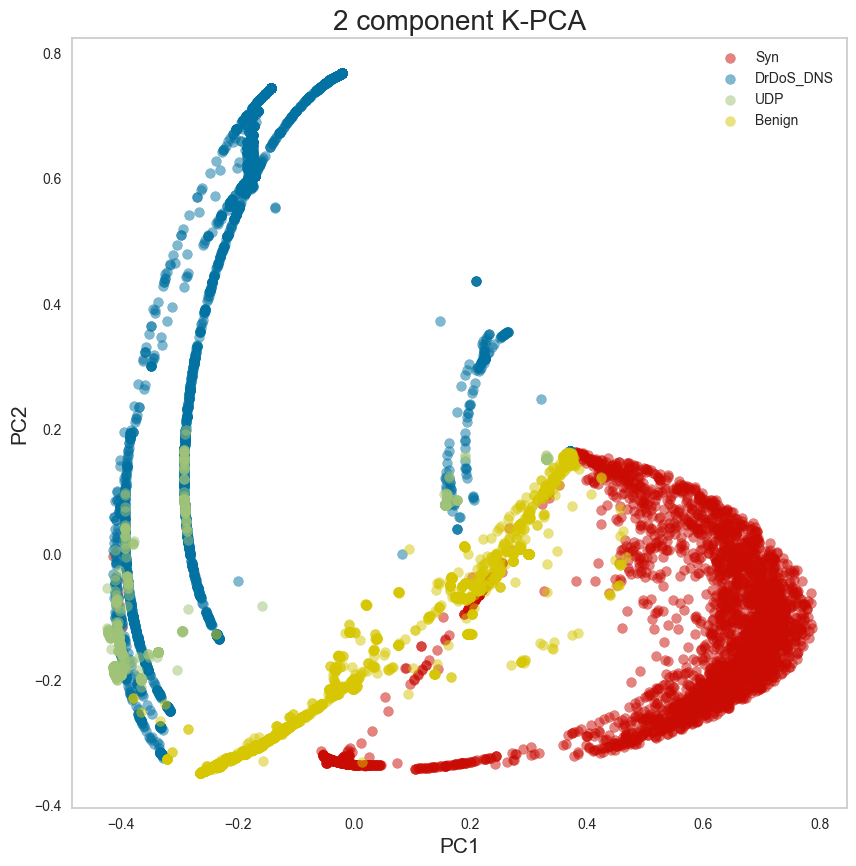

In [349]:
# plot 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('PC1', fontsize=15)
ax.set_ylabel('PC2', fontsize=15)
ax.set_title('2 component K-PCA', fontsize=20)
targets = ['Syn', 'DrDoS_DNS', 'UDP', 'Benign']
colors = ['r', 'b', 'g', 'y']
for target, color in zip(targets, colors):
    indicesToKeep = df_kpca['Label'] == target
    ax.scatter(df_kpca.loc[indicesToKeep, 'PC1'], df_kpca.loc[indicesToKeep, 'PC2'], c=color, s=50 , alpha=0.5)

ax.legend(targets)
ax.grid()
plt.show()


Both the PCA and the kernel-PCA did a good job at reducing the dimensionality of the dataset to a point where we can visualy see the clusters.

but we can see that its hard to distinguish the UDP attacks from the DrDoS_DNS attacks

### t-SNE

In [350]:
from sklearn.manifold import TSNE
import os

# scatter plot the data
def plot_tsne(df_tsne):
    sns.scatterplot(x='PC1', y='PC2', hue='Label', data=df_tsne)
    plt.show()

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 13301 samples in 0.007s...
[t-SNE] Computed neighbors for 13301 samples in 1.038s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13301
[t-SNE] Computed conditional probabilities for sample 2000 / 13301
[t-SNE] Computed conditional probabilities for sample 3000 / 13301
[t-SNE] Computed conditional probabilities for sample 4000 / 13301
[t-SNE] Computed conditional probabilities for sample 5000 / 13301
[t-SNE] Computed conditional probabilities for sample 6000 / 13301
[t-SNE] Computed conditional probabilities for sample 7000 / 13301
[t-SNE] Computed conditional probabilities for sample 8000 / 13301
[t-SNE] Computed conditional probabilities for sample 9000 / 13301
[t-SNE] Computed conditional probabilities for sample 10000 / 13301
[t-SNE] Computed conditional probabilities for sample 11000 / 13301
[t-SNE] Computed conditional probabilities for sample 12000 / 13301
[t-SNE] Computed conditional probabilities for sam

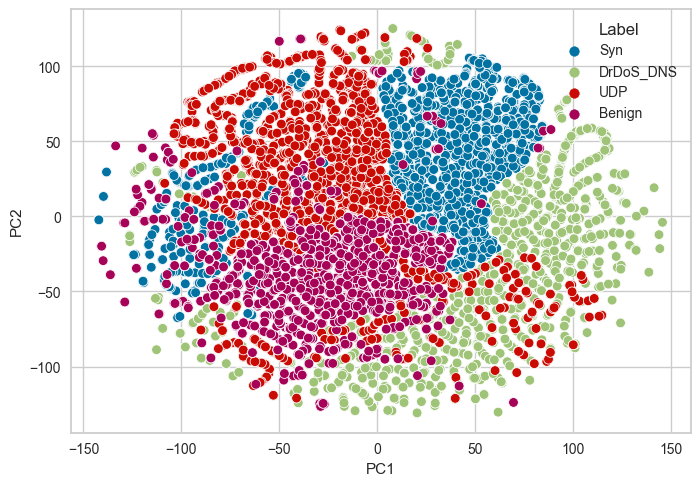

In [351]:
tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=5)
df_tsne = pd.DataFrame(tsne.fit_transform(df.drop('Label', axis=1)), columns=['PC1', 'PC2'])
df_tsne['Label'] = df['Label'].values
plot_tsne(df_tsne)

We can see that the t-SNE algorithm is able to separate the different classes. However, the classes are not enough separated. We need to adjust the perplexity parameter in order to have a better separation.

According to this [article](https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868#:~:text=How%20to%20select%20optimal%20perplexity%3F), The optimal perplexity parameter depends on the number of samples in the dataset. As we have around 13k samples, we can try to set the perplexity to 100.

In order to save_time and avoid to run the t-SNE algorithm for a long time, we will load the data that are already computed and have 

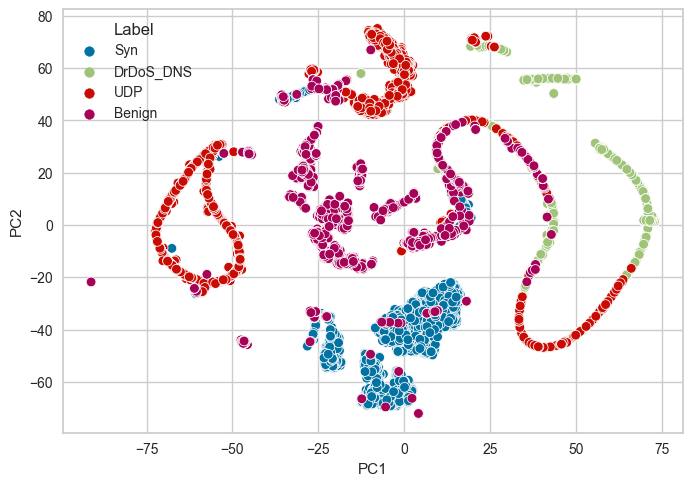

In [352]:
# check if the file 'data/results/df_tsne.parquet' exists
if os.path.isfile('data/results/df_tsne.parquet'):
    df_tsne = pd.read_parquet('data/results/df_tsne.parquet')
else:
    tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=100)
    df_tsne = pd.DataFrame(tsne.fit_transform(df.drop('Label', axis=1)), columns=['PC1', 'PC2'])
    df_tsne['Label'] = df['Label'].values
plot_tsne(df_tsne)


The result looks very good with a perplexity of 100. We can see that the classes are well separated. We only have more difficulty to separate the UDP attacks and Benign traffic. And the UDP attacks are not well separated from the DrDos DNS attacks. The Syn attacks are well separated from the other classes.

Without the Benign traffic, we can see that the clusters are well separated.

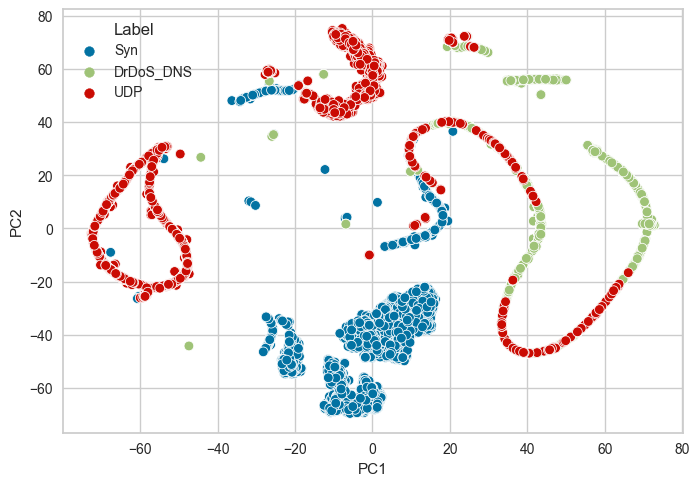

In [353]:
df_tsne_no_benign = df_tsne[df_tsne['Label'] != 'Benign']
plot_tsne(df_tsne_no_benign)

In [354]:
if os.path.isfile('data/results/df_tsne.parquet'):
    df_tsne.to_parquet('data/results/df_tsne.parquet')
if os.path.isfile('data/results/df_tsne_no_benign.parquet'):
    df_tsne_no_benign.to_parquet('data/results/df_tsne_no_benign.parquet')

## Supervised learning for multiclassification

### LDA

In [355]:
# copy the dataframe to a new one
df_lda = df.copy()

# mpa each label to a number
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_lda['Label'])
df_lda['Label'] = le.transform(df_lda['Label'])

In [356]:
# perform LDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_lda.drop('Label', axis=1), df_lda['Label'], test_size=0.2, random_state=42)

# perform LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# make predictions
y_pred = lda.predict(X_test)

# calculate accuracy
accuracy_score(y_test, y_pred)

0.9763246899661782

the overall accuracy is verry high, we can calculate the precision and recall and f1 score for each class

In [357]:
# calculate the accuracy for each class
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: ', precision_score(y_test, y_pred, average=None))
print('Recall: ', recall_score(y_test, y_pred, average=None))
print('F1: ', f1_score(y_test, y_pred, average=None))

Precision:  [0.99812734 0.93810179 0.9930265  0.98243045]
Recall:  [0.9708561  0.99562044 0.99719888 0.94109397]
F1:  [0.98430286 0.96600567 0.99510832 0.96131805]


<Axes: >

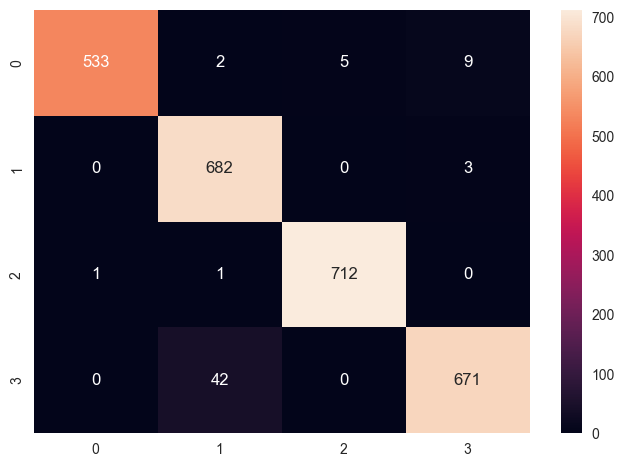

In [358]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

we can comapre it to an Qaudratic Discriminant Analysis
### QDA

In [359]:
# perform QDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

lda = QuadraticDiscriminantAnalysis()
lda.fit(X_train, y_train)

# make predictions
y_pred = lda.predict(X_test)

# calculate accuracy
accuracy_score(y_test, y_pred)

0.9676813228109733

In [360]:
# calculate the accuracy for each class
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: ', precision_score(y_test, y_pred, average=None))
print('Recall: ', recall_score(y_test, y_pred, average=None))
print('F1: ', f1_score(y_test, y_pred, average=None))

Precision:  [0.99275362 0.984      1.         0.90709677]
Recall:  [0.99817851 0.89781022 0.9929972  0.98597475]
F1:  [0.99545867 0.9389313  0.9964863  0.94489247]


both overall and per class accuracy are lower than in an LDA

<Axes: >

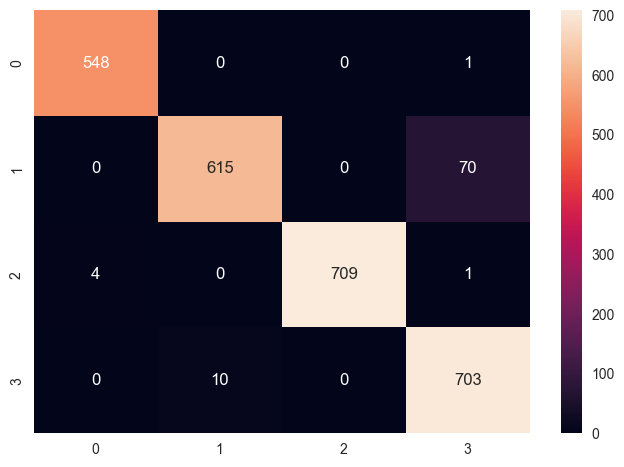

In [361]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

## lets try applying LDA and QDA on the PCA K-PCA and t-SNE

### PCA + LDA

In [362]:
# perform LDA on the pca data
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_pca.drop('Label', axis=1), df_pca['Label'], test_size=0.2, random_state=42)

# perform LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# make predictions
y_pred = lda.predict(X_test)

# calculate the accuracy for each class
print('Precision: ', precision_score(y_test, y_pred, average=None))
print('Recall: ', recall_score(y_test, y_pred, average=None))
print('F1: ', f1_score(y_test, y_pred, average=None))

Precision:  [0.99799599 0.98266898 0.9647651  0.71081901]
Recall:  [0.90710383 0.82773723 0.80532213 0.98597475]
F1:  [0.95038168 0.89857369 0.8778626  0.82608696]


<Axes: >

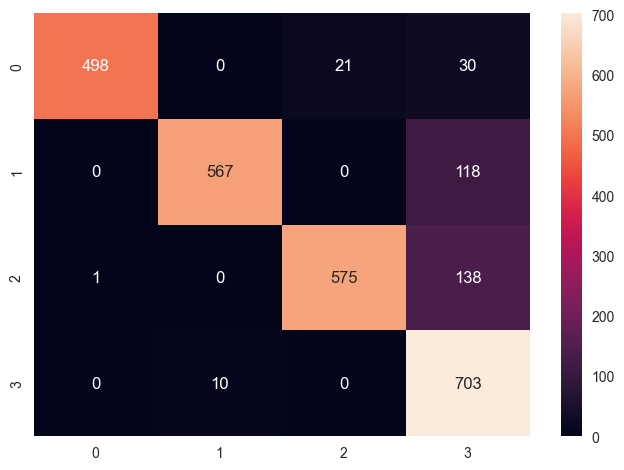

In [363]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

### PCA + QDA

In [364]:
# perform QDA on the pca data
# perform QDA
lda = QuadraticDiscriminantAnalysis()
lda.fit(X_train, y_train)

# make predictions
y_pred = lda.predict(X_test)

# calculate the accuracy for each class
print('Precision: ', precision_score(y_test, y_pred, average=None))
print('Recall: ', recall_score(y_test, y_pred, average=None))
print('F1: ', f1_score(y_test, y_pred, average=None))

Precision:  [0.99454545 0.99512195 0.99859353 0.90573248]
Recall:  [0.99635701 0.89343066 0.99439776 0.99719495]
F1:  [0.99545041 0.94153846 0.99649123 0.94926569]


<Axes: >

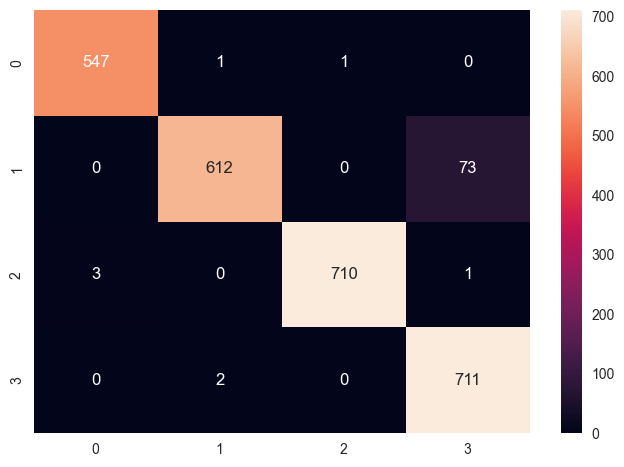

In [365]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

### K-PCA + LDA

In [366]:
# perform LDA on the kpca data
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_kpca.drop('Label', axis=1), df_kpca['Label'], test_size=0.2, random_state=42)

# perform LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# make predictions
y_pred = lda.predict(X_test)

# calculate the accuracy for each class
print('Precision: ', precision_score(y_test, y_pred, average=None))
print('Recall: ', recall_score(y_test, y_pred, average=None))
print('F1: ', f1_score(y_test, y_pred, average=None))

Precision:  [0.97727273 0.95314788 0.96195652 0.95378151]
Recall:  [0.93989071 0.95036496 0.99159664 0.95511921]
F1:  [0.95821727 0.95175439 0.97655172 0.95444989]


<Axes: >

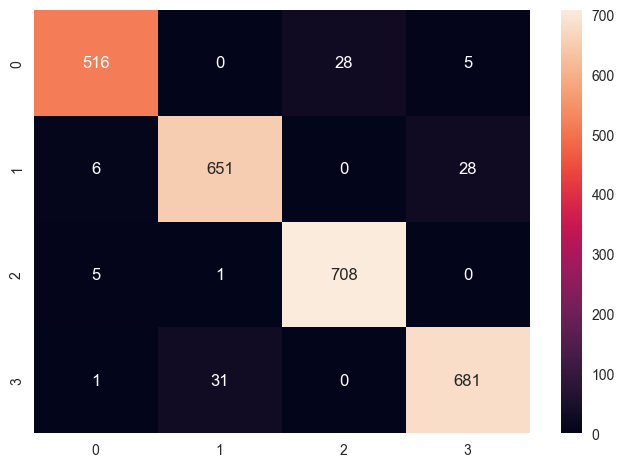

In [367]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

### K-PCA + QDA

In [368]:
# perform QDA on the kpca data
# perform QDA

lda = QuadraticDiscriminantAnalysis()
lda.fit(X_train, y_train)

# make predictions
y_pred = lda.predict(X_test)

# calculate the accuracy for each class
print('Precision: ', precision_score(y_test, y_pred, average=None))
print('Recall: ', recall_score(y_test, y_pred, average=None))
print('F1: ', f1_score(y_test, y_pred, average=None))

Precision:  [0.97981651 0.97280967 0.98063624 0.95348837]
Recall:  [0.9726776  0.94014599 0.9929972  0.97755961]
F1:  [0.976234   0.95619896 0.98677801 0.96537396]


<Axes: >

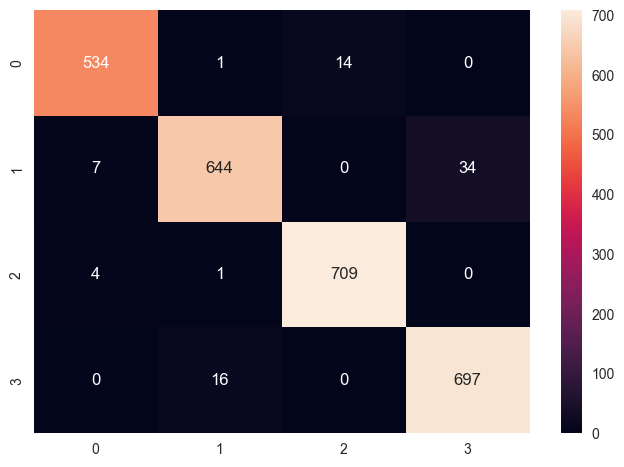

In [369]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

#### T-SNE + LDA

In [370]:
# perform LDA on the t-SNE data
# copy the dataframe to a new one
df_tsne_lda = df_tsne.copy()

# mpa each label to a number
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_tsne_lda['Label'])
df_tsne_lda['Label'] = le.transform(df_tsne_lda['Label'])

In [371]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_tsne_lda.drop('Label', axis=1), df_tsne_lda['Label'], test_size=0.2, random_state=42)

# perform LDA   
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# make predictions
y_pred = lda.predict(X_test)

# calculate the accuracy for each class
print('Precision: ', precision_score(y_test, y_pred, average=None))
print('Recall: ', recall_score(y_test, y_pred, average=None))
print('F1: ', f1_score(y_test, y_pred, average=None))

Precision:  [0.68235294 0.83310902 0.81342282 0.74038462]
Recall:  [0.4084507  0.91432792 0.84992987 0.87749288]
F1:  [0.51101322 0.87183099 0.83127572 0.80312907]


<Axes: >

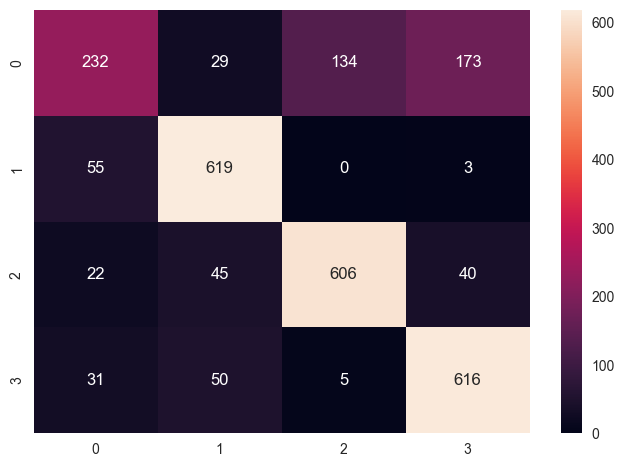

In [372]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

### t-SNE + QDA

In [373]:
# perform QDA on the t-SNE data
# perform QDA
lda = QuadraticDiscriminantAnalysis()
lda.fit(X_train, y_train)

# make predictions
y_pred = lda.predict(X_test)

# calculate the accuracy for each class
print('Precision: ', precision_score(y_test, y_pred, average=None))
print('Recall: ', recall_score(y_test, y_pred, average=None))
print('F1: ', f1_score(y_test, y_pred, average=None))

Precision:  [0.77468354 0.88841202 0.84246575 0.76315789]
Recall:  [0.53873239 0.91728213 0.86255259 0.90883191]
F1:  [0.63551402 0.90261628 0.85239085 0.82964889]


<Axes: >

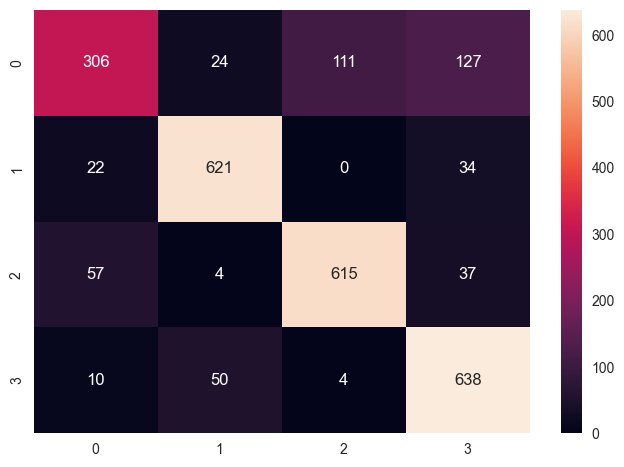

In [374]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

the accuracy is very bad as we are not supposed to use t-SNE for classification

## Unsupervised learning for clustering

### k-Means

In [375]:
from sklearn.cluster import KMeans

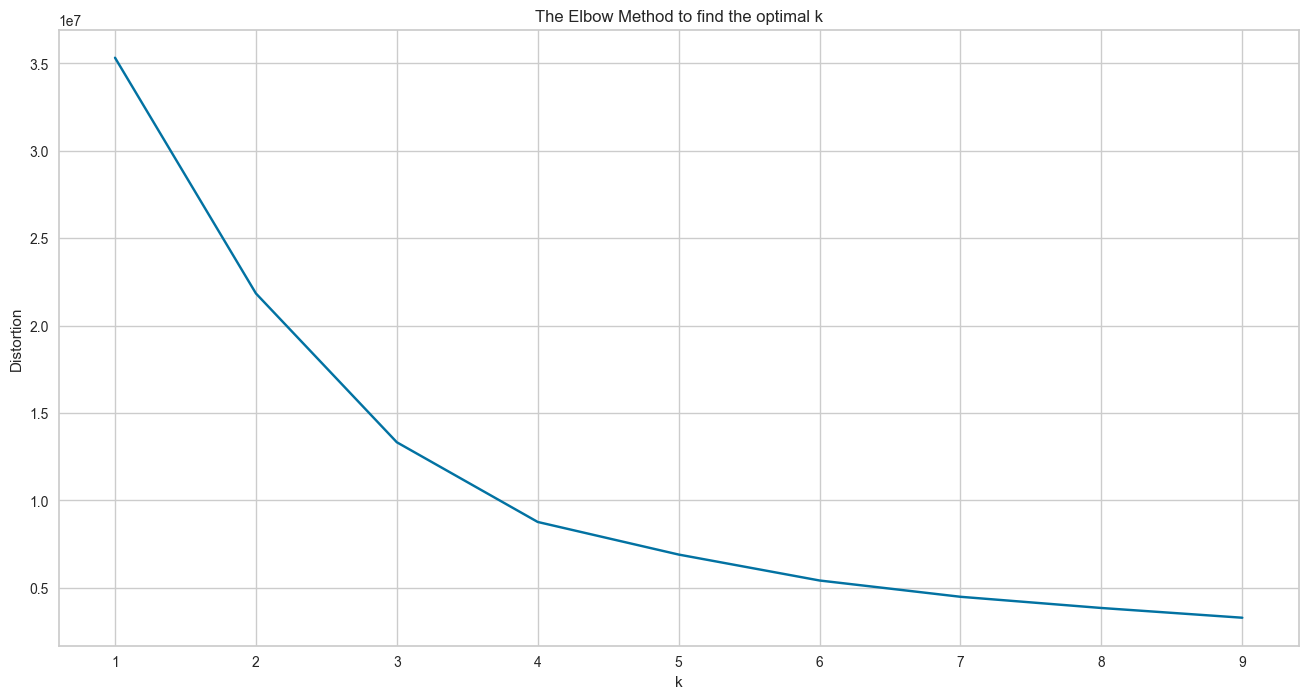

In [376]:
# elbow method to choose the number of clusters
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=123)
    kmeanModel.fit(df_tsne.drop('Label', axis=1))
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method to find the optimal k')
plt.show()

According to the elbow method, the optimal number of clusters is 4, which is coherent with the number of classes in the dataset.

In [377]:
# create kmeans object
N = 4
kmeans = KMeans(n_clusters=N, random_state=123)

# fit kmeans object to data
kmeans.fit(df_tsne[['PC1', 'PC2']])

# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)

[[ 46.657978   -9.370604 ]
 [  5.588282   43.945126 ]
 [-46.138554    3.4791222]
 [ -4.4430556 -40.495106 ]]


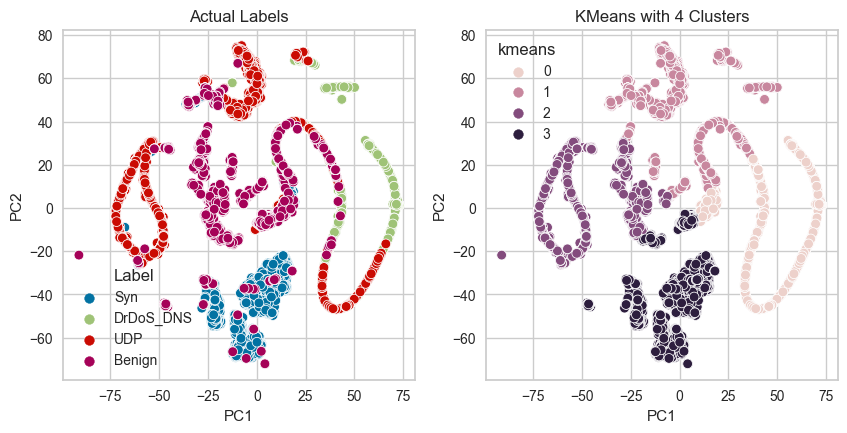

In [378]:
# plot the data and the clusters learned
df_tsne['kmeans'] = kmeans.labels_
fig = plt.figure(figsize=(10, 10))
plt.subplot(221)
sns.scatterplot(x='PC1', y='PC2', hue='Label', data=df_tsne)
plt.title('Actual Labels')
plt.subplot(222)
sns.scatterplot(x='PC1', y='PC2', hue='kmeans', data=df_tsne)
plt.title('KMeans with {} Clusters'.format(N))
plt.show()

We can see that k-means is not able to separate the data into the correct clusters. This is because the shape of the k-means' clusters is always spherical, and it looks for clusters of equal variance, which in this case, is not the case.

We will try to use the k-means algorithm with the t-SNE results without the Benign traffic.

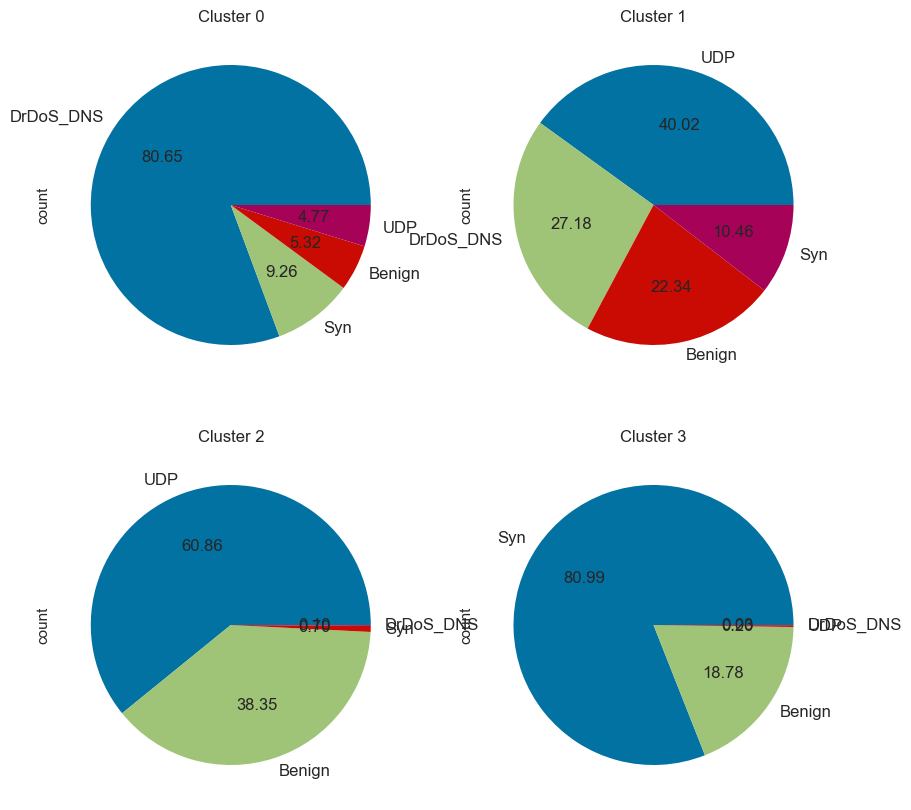

In [379]:
# create a plot grid of 2x2
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# plot the pie charts of distributions of labels for each cluster
for i in range(4):
    df_tsne[df_tsne['kmeans'] == i]['Label'].value_counts().plot.pie(ax=ax[i//2][i%2], autopct='%.2f', fontsize=12)
    ax[i//2][i%2].set_title('Cluster {}'.format(i))
plt.show()

We can see that 3 of the 4 clusters are almost fully constituted of one attack class but we still have trouble to separate the Benign traffic from the attacks as the Benign traffic is mixed among the 4 clusters.

0.42762336


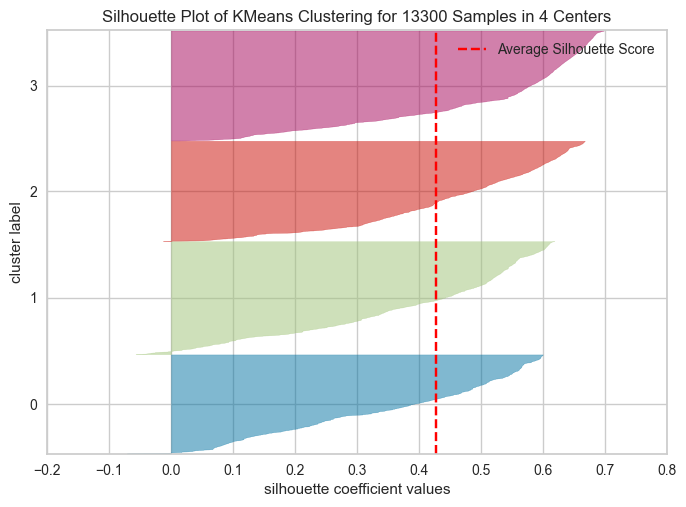

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 13300 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [380]:
# evaluate the performance of the clustering using the silouette score
from sklearn.metrics import silhouette_score
print(silhouette_score(df_tsne[['PC1', 'PC2']], kmeans.labels_))

# plot the silhouette for the various clusters
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df_tsne[['PC1', 'PC2']])
visualizer.show()

The silhouette plot is a graphical tool presenting how well our data points fit into the clusters they’ve been assigned to and how well they would fit into other clusters. The silhouette coefficient is a measure of cluster cohesion and separation.

### GMM

In [381]:
from sklearn.mixture import GaussianMixture

In [382]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=123)
gmm.fit(df_tsne[['PC1', 'PC2']])
df_tsne['gmm'] = gmm.predict(df_tsne[['PC1', 'PC2']])

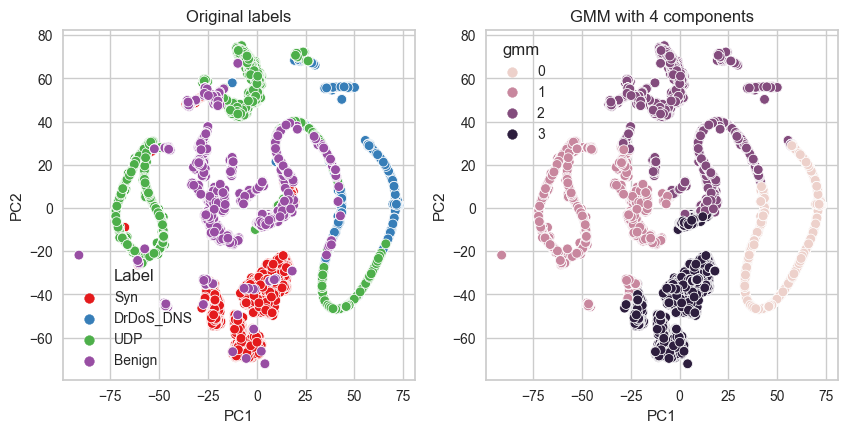

In [383]:
# plot the results
fig = plt.figure(figsize=(10, 10))
plt.subplot(221)
sns.scatterplot(x='PC1', y='PC2', hue='Label', data=df_tsne, palette='Set1')
plt.title('Original labels')
plt.subplot(222)
sns.scatterplot(x='PC1', y='PC2', hue='gmm', data=df_tsne)
plt.title('GMM with {} components'.format(df_tsne['gmm'].nunique()))
plt.show()

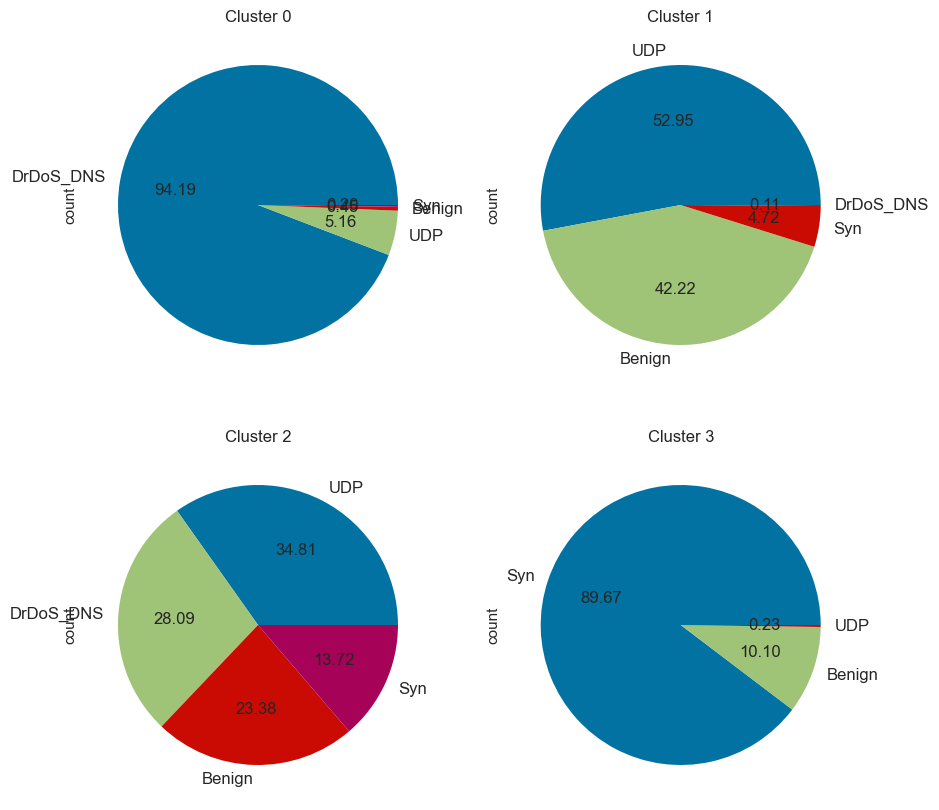

In [384]:
# create a plot grid of 2x2
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# plot the pie charts of distributions of labels for each cluster
for i in range(4):
    df_tsne[df_tsne['gmm'] == i]['Label'].value_counts().plot.pie(ax=ax[i//2][i%2], autopct='%.2f', fontsize=12)
    ax[i//2][i%2].set_title('Cluster {}'.format(i))
plt.show()

### DBSCAN

In [385]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.7, min_samples= 15).fit(df_tsne[['PC1', 'PC2']])
df_tsne['dbscan'] = dbscan.labels_

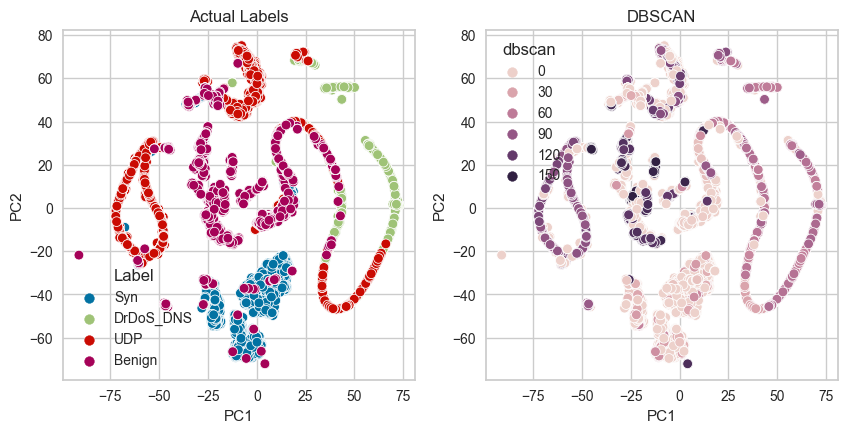

In [386]:
# plot the data and the clusters learned
fig = plt.figure(figsize=(10, 10))
plt.subplot(221)
sns.scatterplot(x='PC1', y='PC2', hue='Label', data=df_tsne)
plt.title('Actual Labels')
plt.subplot(222)
sns.scatterplot(x='PC1', y='PC2', hue='dbscan', data=df_tsne)
plt.title('DBSCAN')
plt.show()

We can see that the DBSCAN algorithm creates more than 100 clusters, wich is not what we want. We need to check for the best eps parameter in order to have a realistic number of clusters.

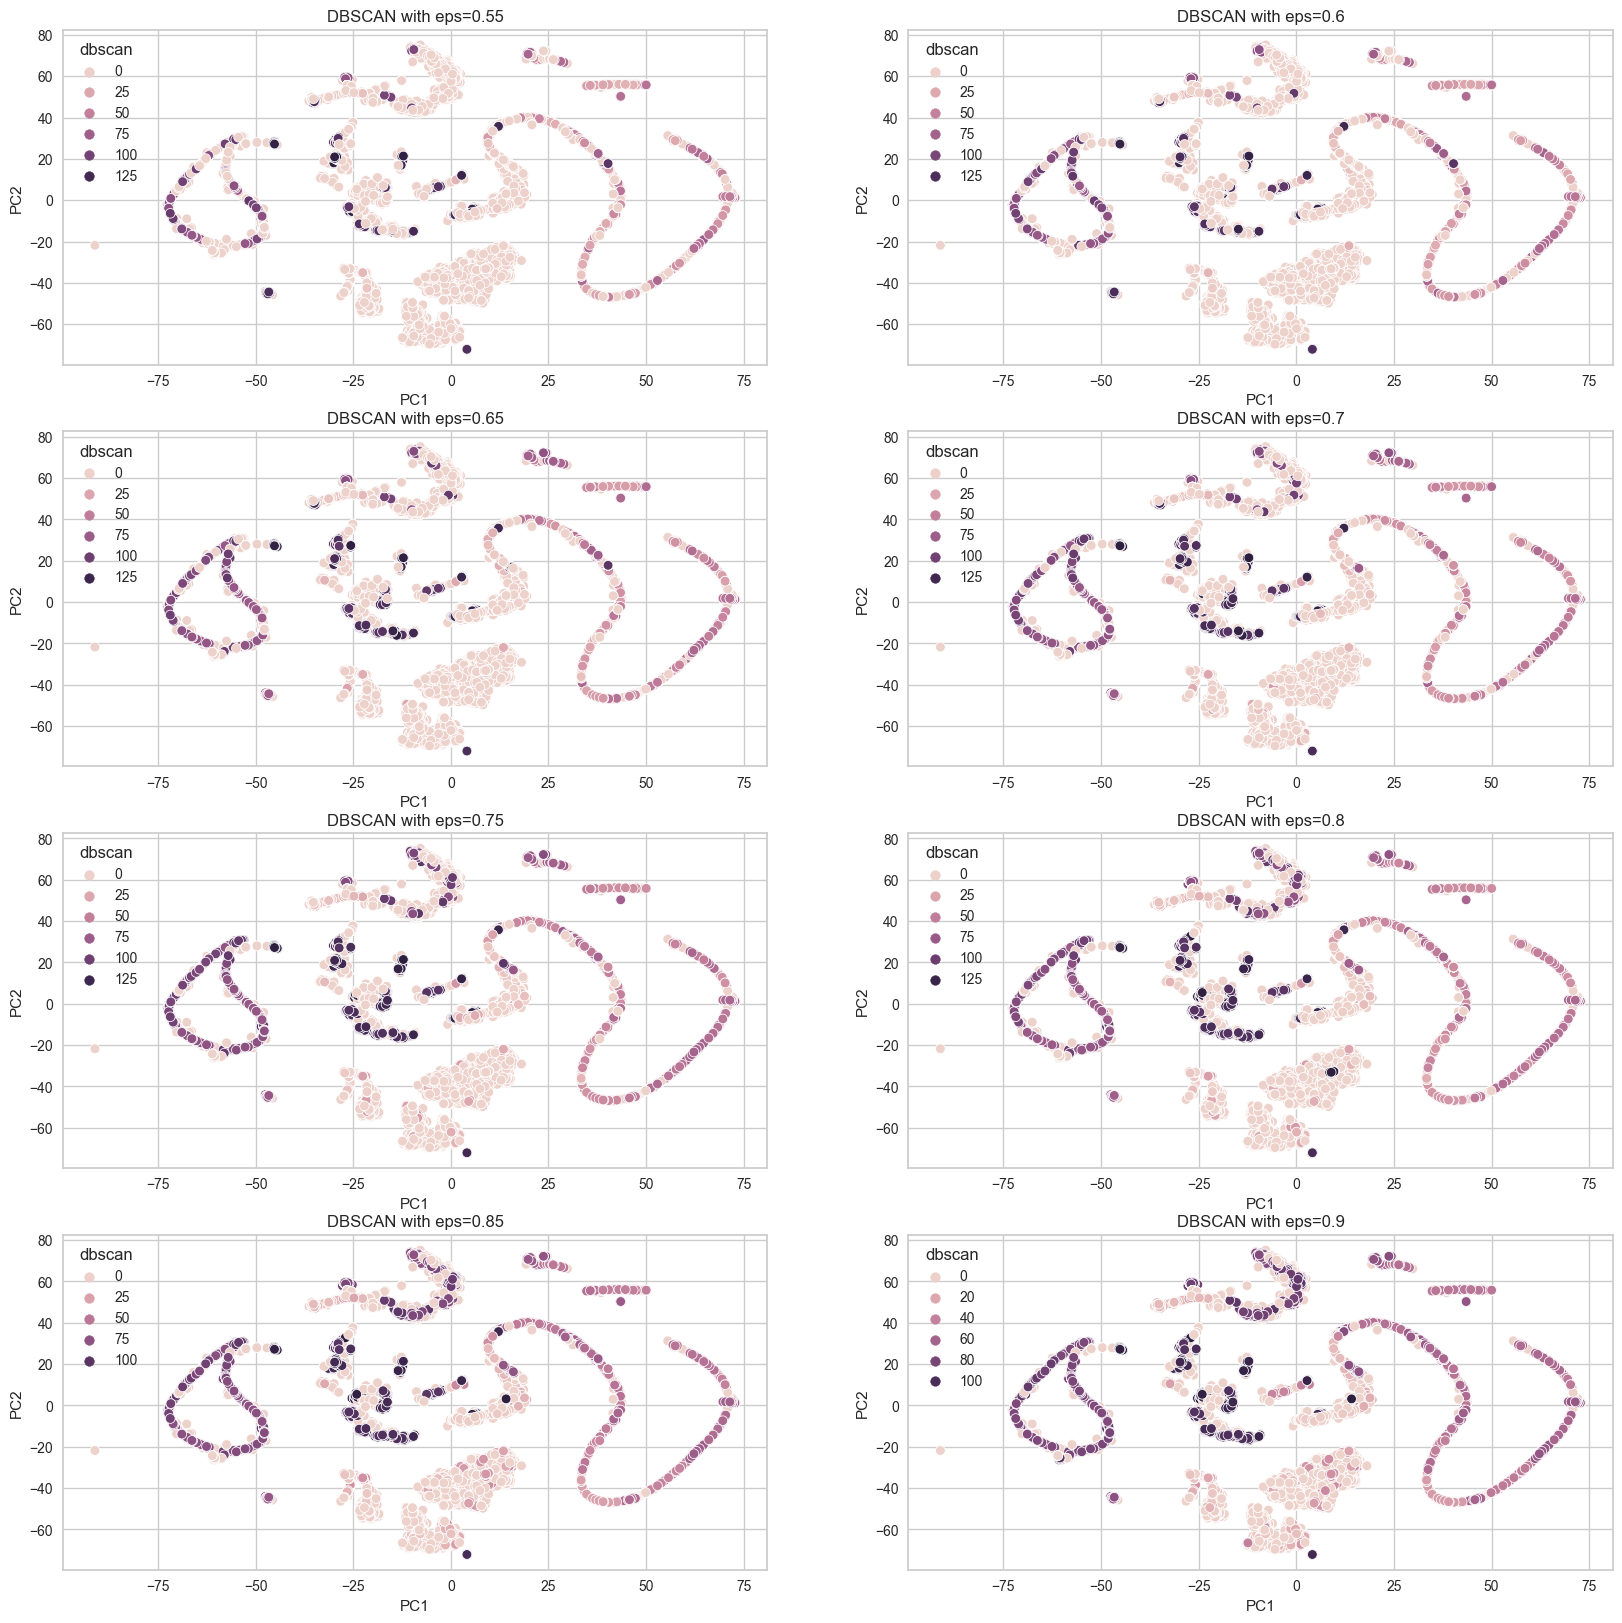

In [387]:
EPS = [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for eps in EPS:
    dbscan = DBSCAN(eps=eps, min_samples= 20).fit(df_tsne[['PC1', 'PC2']])
    df_tsne['dbscan'] = dbscan.labels_
    # plot the data and the clusters learned
    sns.scatterplot(x='PC1', y='PC2', hue='dbscan', data=df_tsne, ax=ax[EPS.index(eps)//2][EPS.index(eps)%2])
    ax[EPS.index(eps)//2][EPS.index(eps)%2].set_title('DBSCAN with eps={}'.format(eps))
plt.show()

### Hierarchical clustering

In [388]:
import numpy as np
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [389]:
def euclidean_distance(*args):
    return np.sqrt(np.sum((args[0] - args[1]) ** 2))

For the hierarchical clustering, we will first use a subsample of the dataset in order to have a better visualization of the dendrogram.

In [390]:
samples = df_tsne.sample(100)

<Axes: >

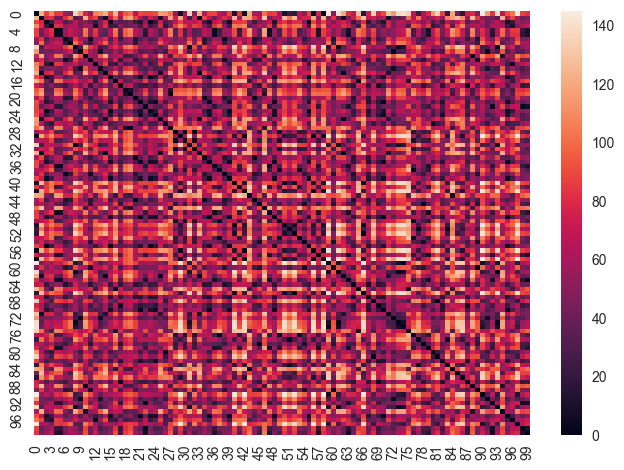

In [391]:
# compute the distance matrix between all the points
distance_matrix = np.zeros((samples[['PC1', 'PC2']].shape[0], samples[['PC1', 'PC2']].shape[0]))
for i in range(samples[['PC1', 'PC2']].shape[0]):
    for j in range(samples[['PC1', 'PC2']].shape[0]):
        distance_matrix[i, j] = euclidean_distance(samples[['PC1', 'PC2']].iloc[i], samples[['PC1', 'PC2']].iloc[j])

sns.heatmap(distance_matrix)

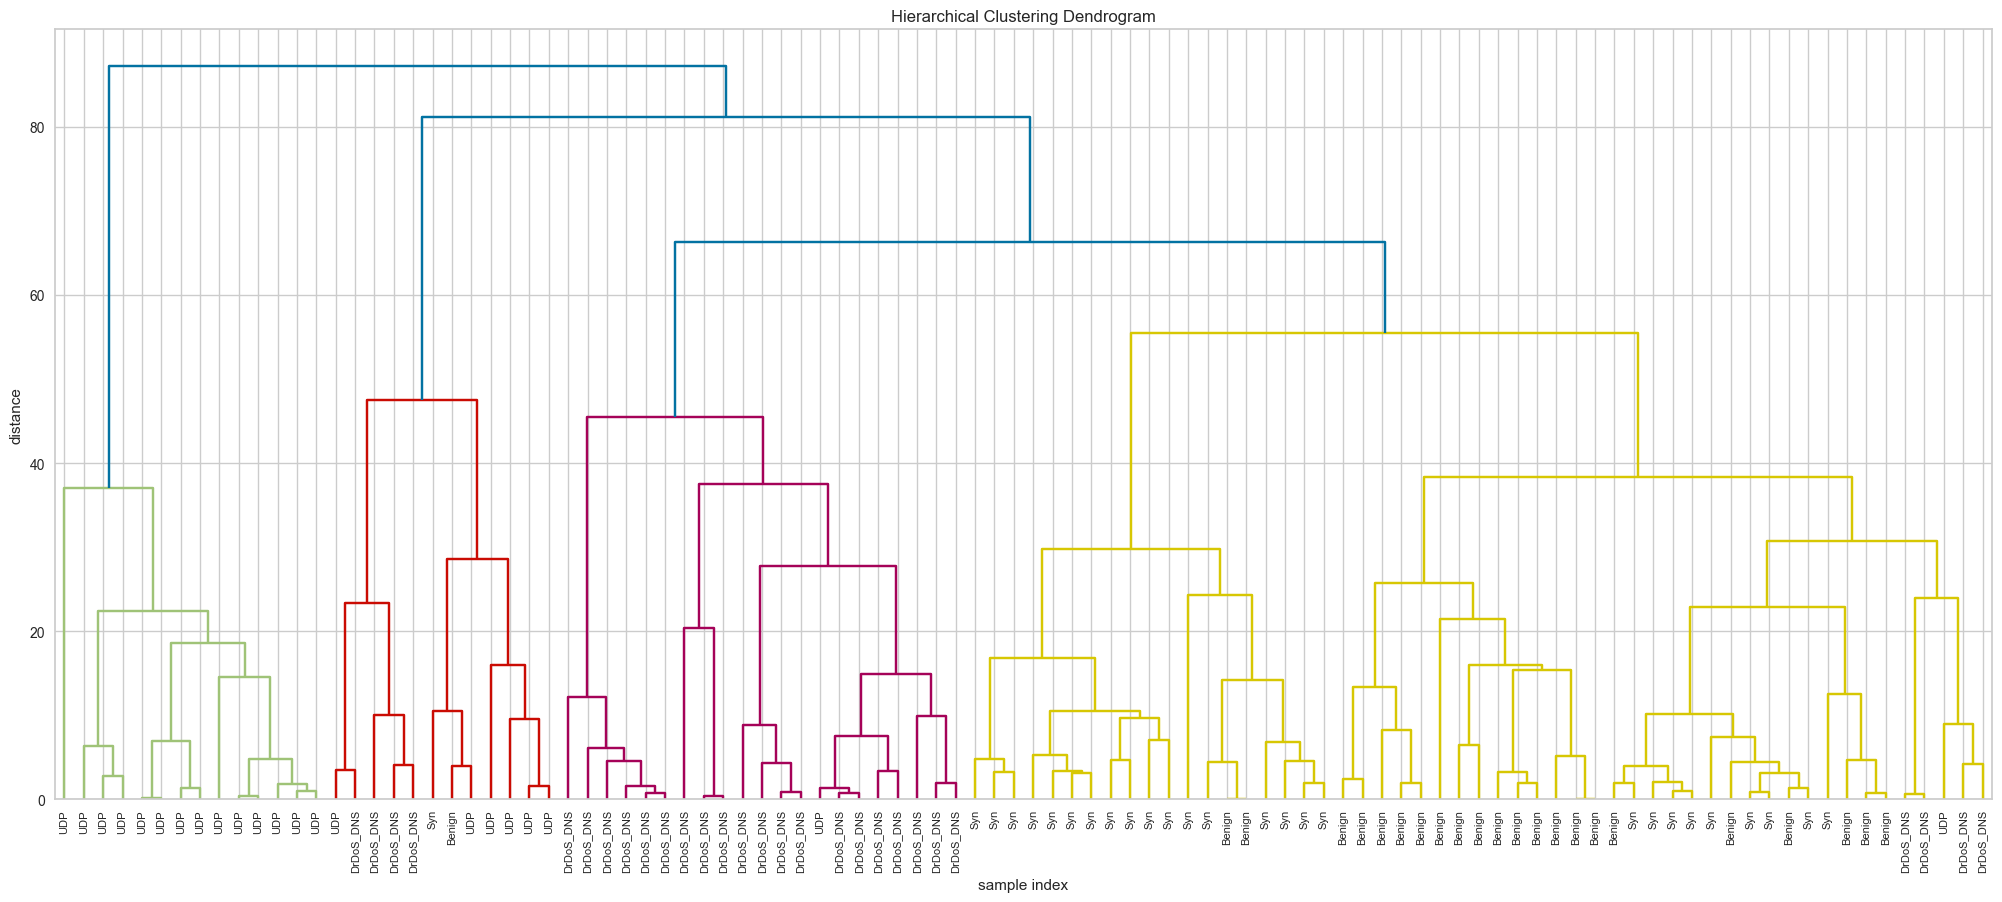

In [392]:
# compute the linkage matrix
Z = linkage(samples[['PC1', 'PC2']], method='average', metric='euclidean')

# plot the dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8., labels=samples['Label'].values)
plt.show()

We can see that the hierarchical clustering is able to separate the different types of attacks, however, the benign traffic is mixed among the different clusters.

We can try to perform the hierarchical clustering algorthm after having classified the Benign traffic from the attacks thanks to the LDA model.

In [393]:
samples_no_benign = df_tsne_no_benign.sample(100)

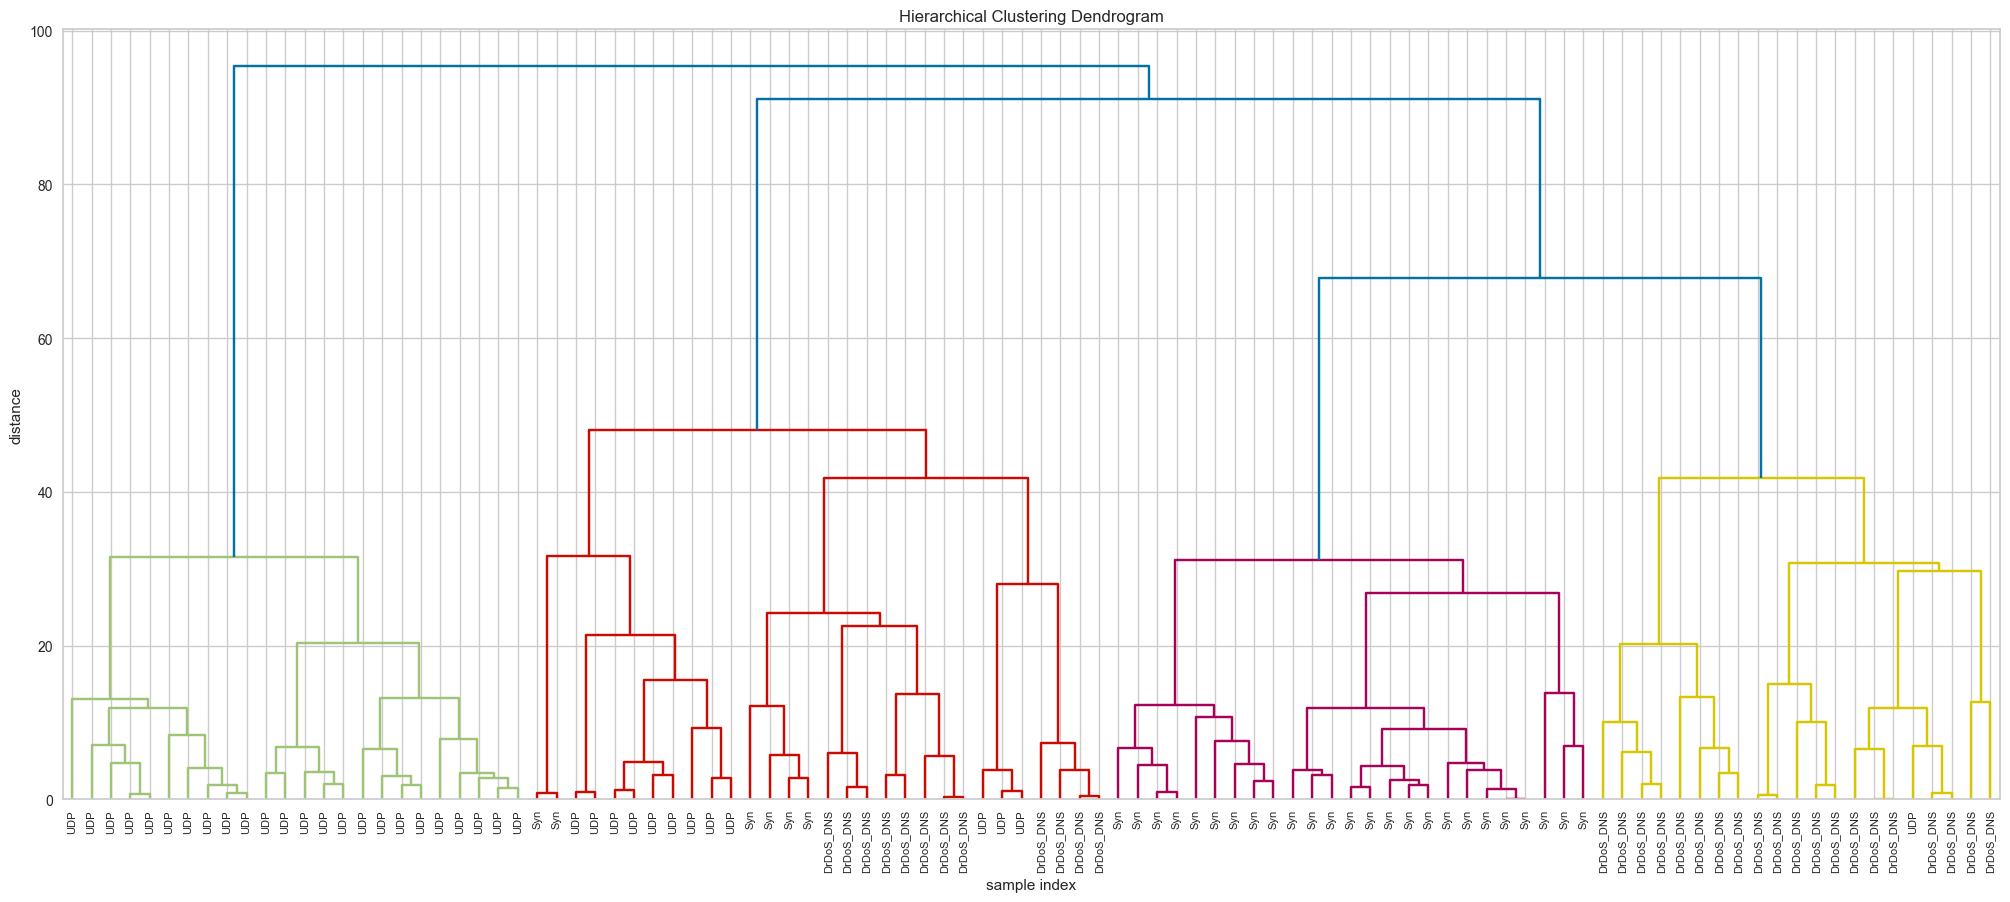

In [394]:
Z_no_benign = linkage(samples_no_benign[['PC1', 'PC2']], method='average', metric='euclidean')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z_no_benign, leaf_rotation=90., leaf_font_size=8., labels=samples_no_benign['Label'].values)
plt.show()

We can see that without the Benign class, the hierarchical clustering with euclidean distance has very good results on the 3 classes. We clearly see 3 clusters (orange, green and red) corresponding to each class. However, we still have One big cluster with a mix of UDP, DrDoS_DNS and a little bit of Syn.

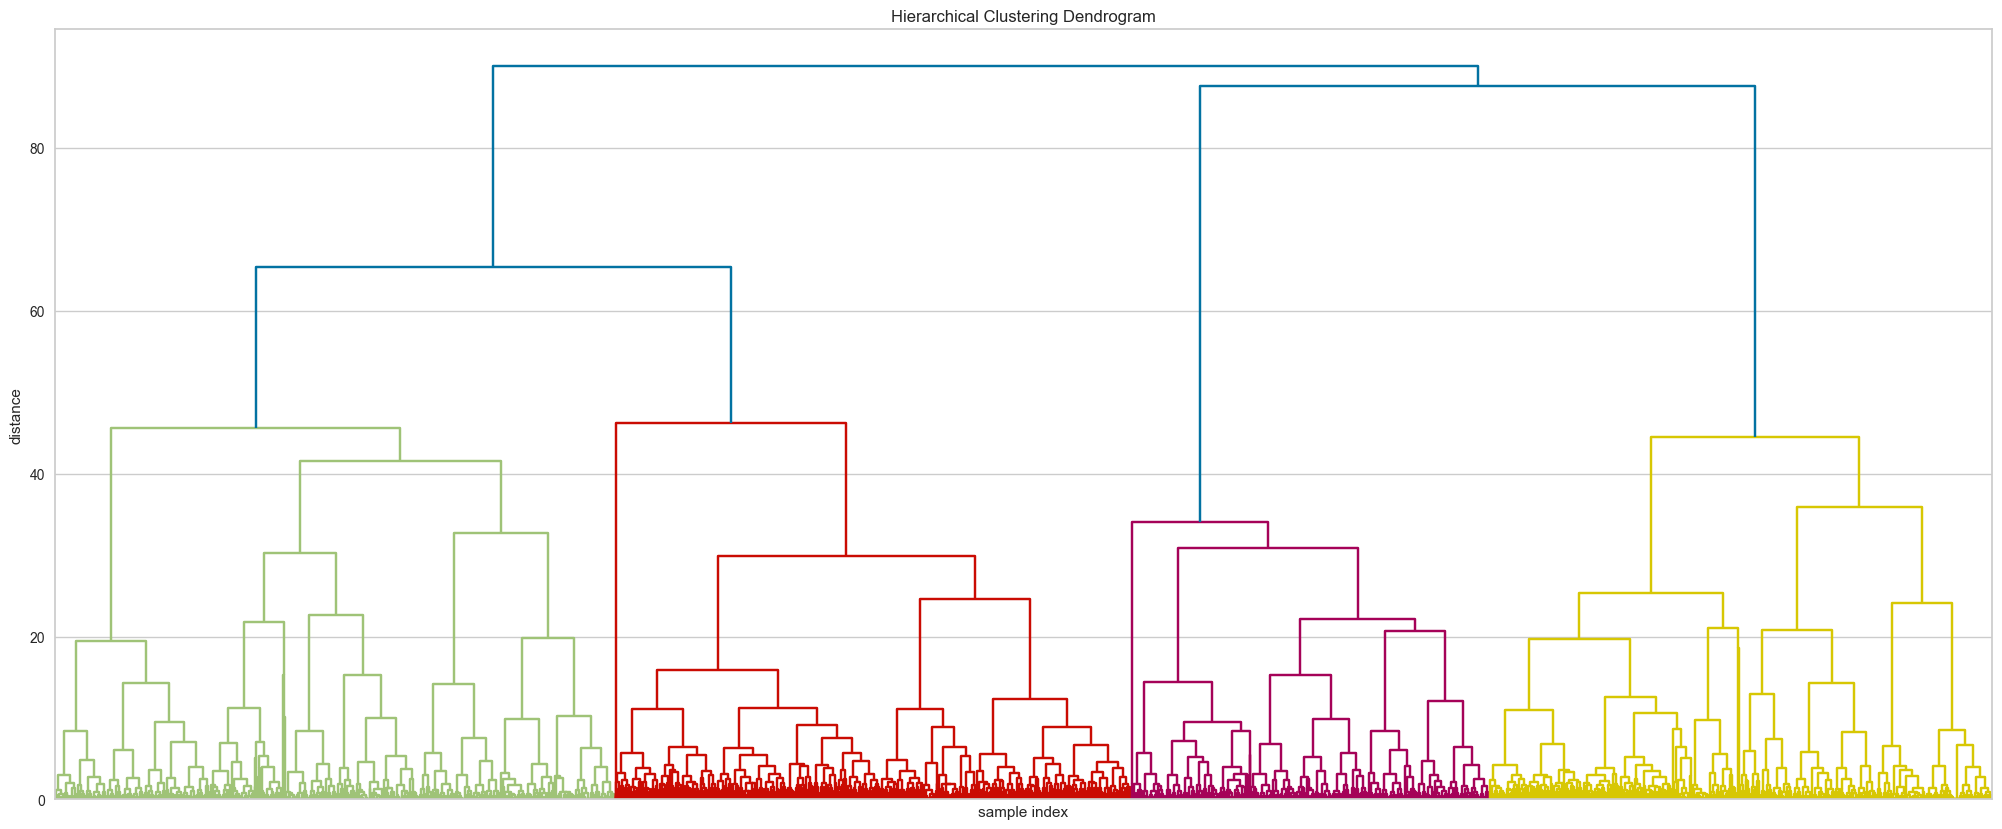

In [395]:
Z_full = linkage(df_tsne_no_benign[['PC1', 'PC2']], method='average', metric='euclidean')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z_full, leaf_rotation=90., leaf_font_size=8., no_labels=True)
plt.show()

We can see that we have 4 main clusters (orange, green, red and blue) whereas we should get only 3 classes. Let's see the proportions of each class in each cluster.

In [396]:
df_tsne_no_benign['hierarchical'] = cut_tree(Z_full, n_clusters=4)

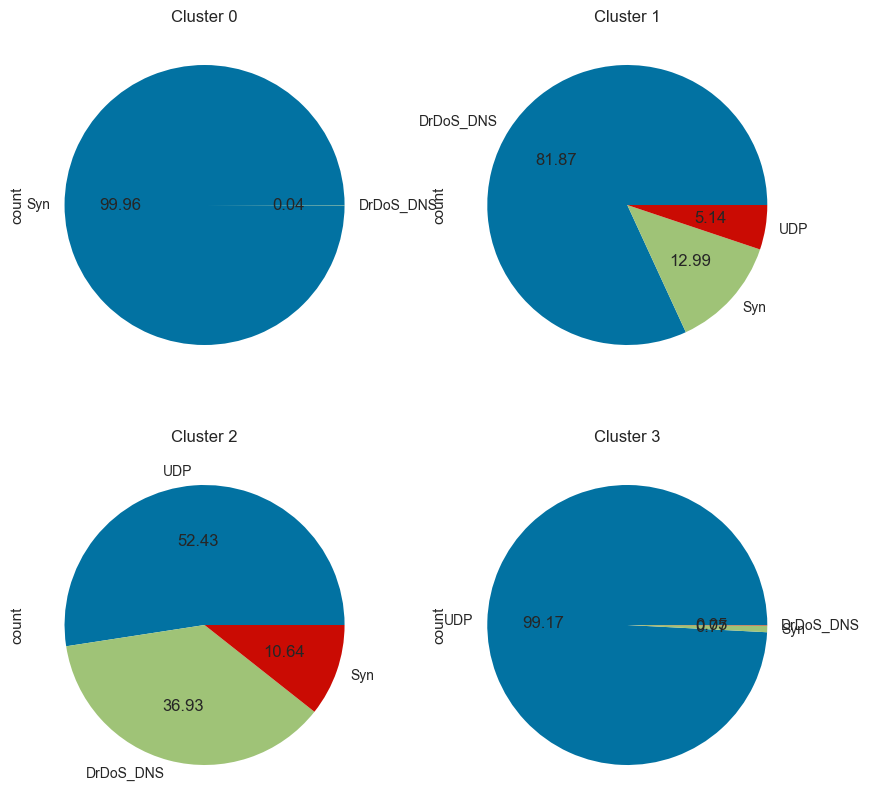

In [397]:
# plot the pie charts of distributions of labels for each cluster
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
    df_tsne_no_benign[df_tsne_no_benign['hierarchical'] == i]['Label'].value_counts().plot.pie(ax=ax[i // 2, i % 2], title='Cluster {}'.format(i), autopct='%.2f')
plt.show()


We can see that we have 3 clusters that are almost only composed of one class. The DrDoS DNS and UDP attacks can't be sparated in the same cluster. However, the Syn attacks are well separated from the other classes.

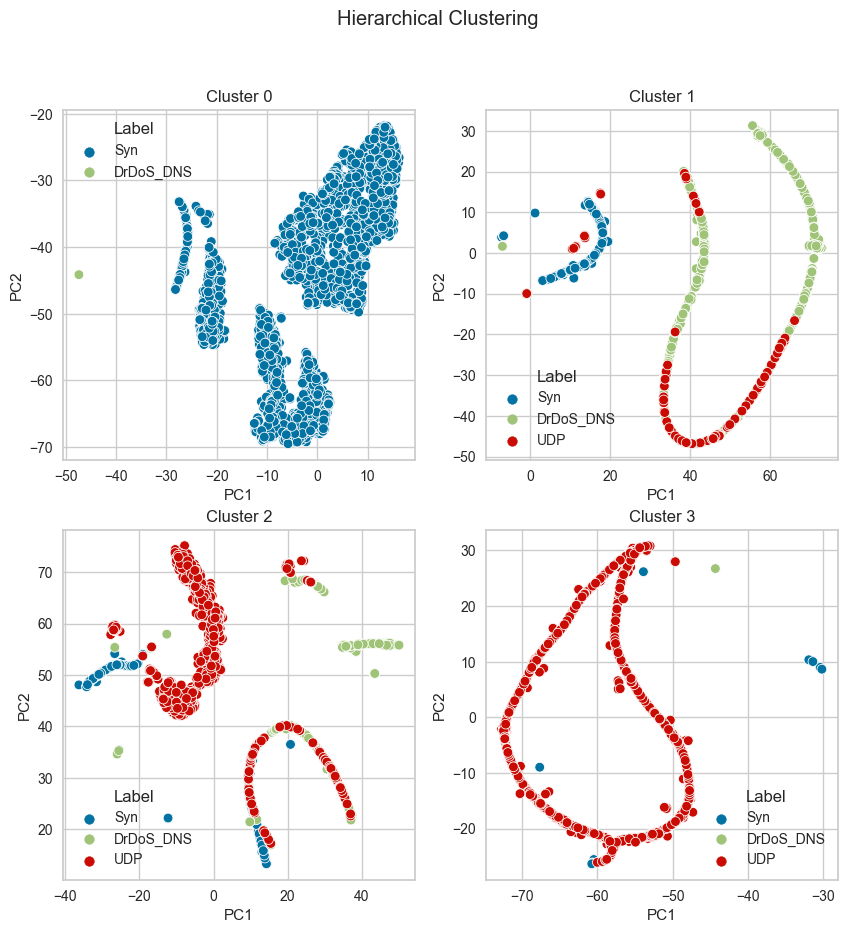

In [398]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for cluster in range(0, df_tsne_no_benign['hierarchical'].nunique()):
    sns.scatterplot(x='PC1', y='PC2', hue='Label', data=df_tsne_no_benign[df_tsne_no_benign['hierarchical'] == cluster], ax=ax[cluster // 2, cluster % 2])
    ax[cluster // 2, cluster % 2].set_title('Cluster {}'.format(cluster))
# set the title of the plot
plt.suptitle('Hierarchical Clustering')
plt.show()

As the classes are well separated inside each cluster, it could be possible to use a supervised learning algorithm to classify the data after the hierarchical clustering.